In [1]:
%load_ext autoreload
%autoreload 2

In [157]:
import pyodbc
import pandas as pd  # sure takes a long time

import numpy as np
import umap
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

import dizzy_util as util
import eval_util
import pseudo_label
import cluster_umap
import cluster

In [104]:
import tensorflow as tf

In [3]:
pos_dataset = util.extractDataset("B00_ML4TrgPos_", {"Note", "WithRole", "AllMed", "Vital", "HF", "DispensedDrug"})

TABLE_CATALOG TABLE_SCHEMA  \
0   ORD_Singh_201911038D         Dflt   
1   ORD_Singh_201911038D         Dflt   
2   ORD_Singh_201911038D         Dflt   
3   ORD_Singh_201911038D         Dflt   
4   ORD_Singh_201911038D         Dflt   
5   ORD_Singh_201911038D         Dflt   
6   ORD_Singh_201911038D         Dflt   
7   ORD_Singh_201911038D         Dflt   
8   ORD_Singh_201911038D         Dflt   
9   ORD_Singh_201911038D         Dflt   
10  ORD_Singh_201911038D         Dflt   
11  ORD_Singh_201911038D         Dflt   
12  ORD_Singh_201911038D         Dflt   
13  ORD_Singh_201911038D         Dflt   

                                           TABLE_NAME  TABLE_TYPE  
0                 _B00_ML4TrgPos_Y201621_01_04_cohort  BASE TABLE  
1          _B00_ML4TrgPos_Y201621_01_04_Demorgraphics  BASE TABLE  
2                    _B00_ML4TrgPos_Y201621_04_04_Lab  BASE TABLE  
3                    _B00_ML4TrgPos_Y201621_05_04_Rad  BASE TABLE  
4           _B00_ML4TrgPos_Y201621_06_Med_04_RxOutpat  BASE TABLE  
5   _B00_ML4TrgPos_Y201621_06_Med_05_BCMA_Dispense...  BASE TABLE  
6           _B00_ML4TrgPos_Y201621_06_Med_07_NonVAMed  BASE TABLE  
7             _B00_ML4TrgPos_Y201621_06_Med_08_AllMed  BASE TABLE  
8                   _B00_ML4TrgPos_Y201621_08_Consult  BASE TABLE  
9                       _B00_ML4TrgPos_Y201621_12_ICD  BASE TABLE  
10                    _B00_ML4TrgPos_Y201621_14_Vital  BASE TABLE  
11                       _B00_ML4TrgPos_Y201621_16_HF  BASE TABLE  
12                     _B00_ML4TrgPos_Y201621_30_Note  BASE TABLE  
13            _B00_ML4TrgPos_Y201621_30_Note_WithRole  BASE TABLE

dict_keys(['cohort', 'Demorgraphics', 'Lab', 'Rad', 'RxOutpat', 'NonVAMed', 'Consult', 'ICD'])


In [4]:
dizziness_df, label_map = util.retrieveLabels()
dizziness_df["DxErrorERCoded"].value_counts()
label_df = util.convertLabelMap(label_map)
pos_datasubset = util.extractAndStandarizeCohort(pos_dataset, "Dizziness")

In [5]:
nomod_mod_label_df = label_df[(label_df.Label == "NoMOD") | (label_df.Label == "MOD")].copy()
nomod_mod_label_df.reset_index(inplace=True, drop=True)

In [ ]:
nomod_mod_label_df

In [7]:
icd_df = pos_datasubset["ICD"]
cohort_df = pos_datasubset["cohort"]
outpat_df = pos_datasubset["RxOutpat"]
rad_df = pos_datasubset["Rad"]
demo_df = pos_datasubset["Demorgraphics"]
consult_df = pos_datasubset["Consult"]

In [8]:
edstart = util.extractFirstVisitIndexDatetime(pos_datasubset["cohort"])

# Feature Extraction

In [9]:
# extract patient age
age_feature = util.makeAgeFeature(demo_df)

In [10]:
# extract patient ER visit time features
index_feature = util.makeIndexFeature(cohort_df)

In [11]:
# fiter ICDs to only look at those before ER index visit
filtered_icd_df = util.filterDFByTimes(icd_df, util.ICD_PATIENT_ID, "DiagDateTime", edstart)

In [ ]:
# extract presence of important risk factor ICDs and count
icd_vec = util.makeNewICDVec(filtered_icd_df)
display(icd_vec)
icd_feature = util.Feature(icd_vec, "PatientSSN")

In [ ]:
# extract whether patient got a stroke diagnosis at ED visit
icd_diag_df = util.findERDiagnosis(icd_df, cohort_df)
display(icd_diag_df)
icd_codes = util.getICDCodes()
print(icd_codes.keys())
stroke_diags = util.filterDFByCodeSet(icd_diag_df, "ICD", icd_codes['Hx of stroke or TIA'])
icd_diag_vec = pd.DataFrame({"PatientSSN":stroke_diags.PatientSSN.unique()})
icd_diag_vec["HasStrokeDiag"] = 1
display(icd_diag_vec)
icd_diag_feature = util.Feature(icd_diag_vec, "PatientSSN")

In [14]:
# extract whether patient got a neurology consult
# consult_feature = util.makeConsultFeature(pos_datasubset["Consult"], cohort_df, edstart)
consult_feature = util.Feature(util.makeNewConsultVec2(consult_df, cohort_df, edstart))

In [15]:
# extract whether patient got a CT or MRI
# rad_feature = util.makeRadFeature(pos_datasubset["Rad"], cohort_df, edstart)
rad_feature = util.Feature(util.makeNewRadVec2(rad_df, cohort_df, edstart))

In [16]:
feature_vec = util.mergeFeatures([consult_feature, rad_feature, age_feature, index_feature, icd_diag_feature, icd_feature])

In [260]:
label_df.to_csv("temp.csv")

In [ ]:
label_df[(label_df.Label != 'MOD') & (label_df.Label != 'NoMOD')]

In [17]:
# filter out PMOD and CodingErrors from vectors
labeled_mnm_feature_vec = feature_vec.merge(label_df, how="outer")
labeled_mnm_feature_vec = labeled_mnm_feature_vec.fillna("Unknown")
labeled_mnm_feature_vec = labeled_mnm_feature_vec[(labeled_mnm_feature_vec.Label != "PMOD") & (labeled_mnm_feature_vec.Label != "CodingEr")].copy()
labeled_mnm_feature_vec.reset_index(inplace=True, drop=True)
mnm_feature_vec = labeled_mnm_feature_vec.drop(["Label"], axis=1, inplace=False)

In [ ]:
mnm_feature_vec.drop(["PatientSSN"], axis=1, inplace=False)

### UMAP to test features

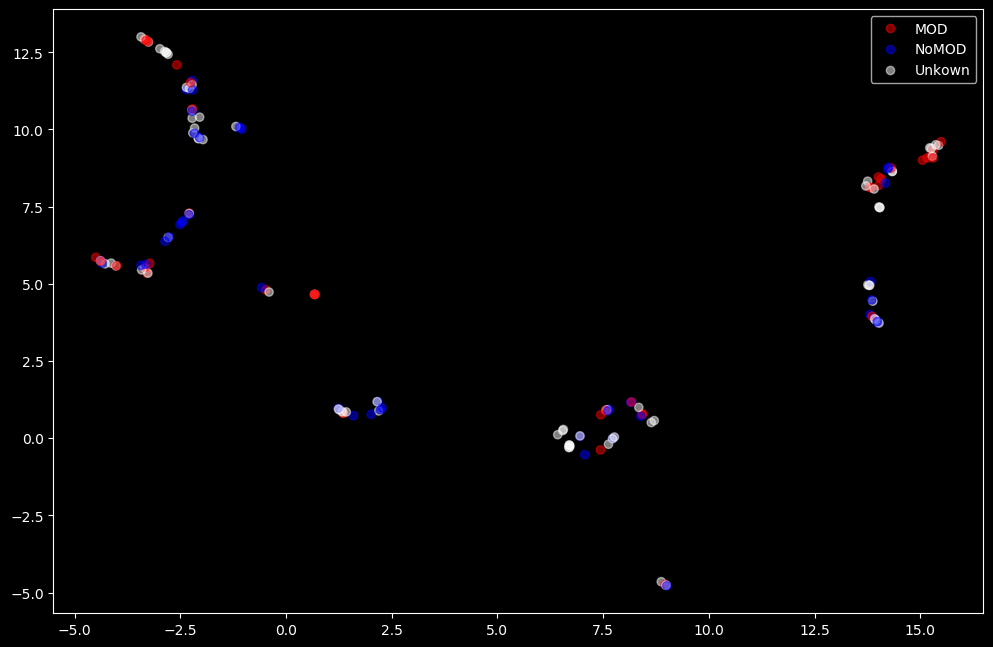

In [21]:
reducer = umap.UMAP(metric="correlation", min_dist=0, n_neighbors=5)
embedding = util.UMAPPlot(reducer, mnm_feature_vec, label_map)

In [158]:
cluster.findBestClusters(embedding, 9, 3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

    MOD  NoMOD  Unlabeled
0   1.0    6.0        7.0
1   6.0    4.0        7.0
2   5.0    1.0       10.0
3   6.0    8.0       17.0
4   6.0    3.0        8.0
5   1.0    6.0        7.0
6   1.0    1.0        3.0
7   1.0    8.0       10.0
8   4.0    1.0        2.0
9   6.0    0.0        5.0
10  1.0    6.0        2.0


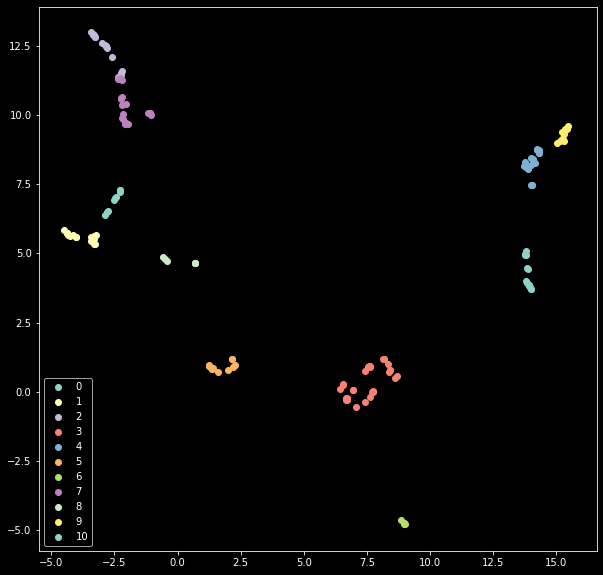

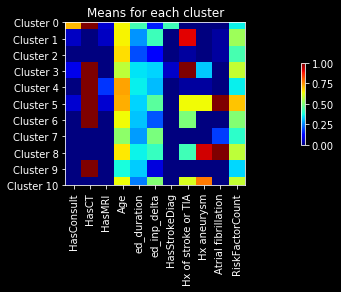

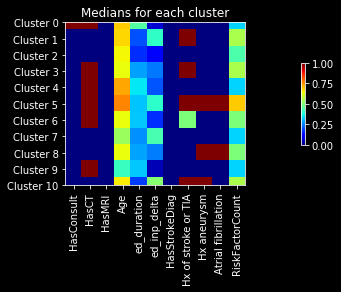

In [55]:
cluster_df = cluster_umap.run_clustering_on_umap(embedding, 11, mnm_feature_vec, nomod_mod_label_df)

    MOD  NoMOD  Unlabeled
0   1.0    1.0        3.0
1   7.0   10.0        9.0
2  12.0    3.0       13.0
3   2.0    9.0       12.0
4   6.0    8.0       17.0
5   1.0    6.0        7.0
6   1.0    6.0        7.0
7   4.0    1.0        2.0
8   4.0    0.0        8.0


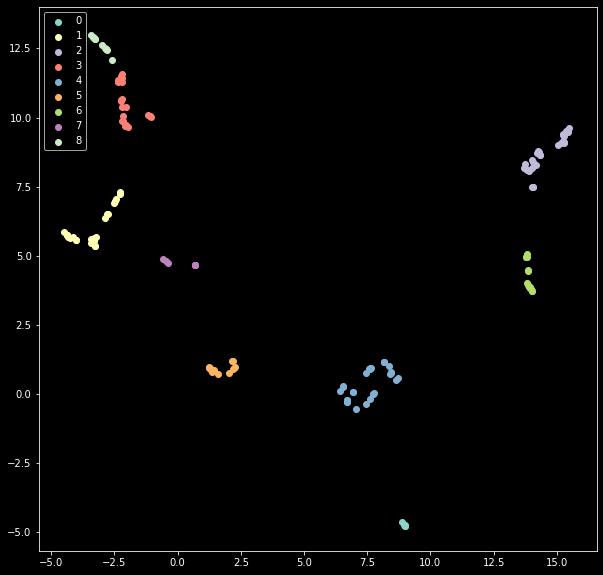

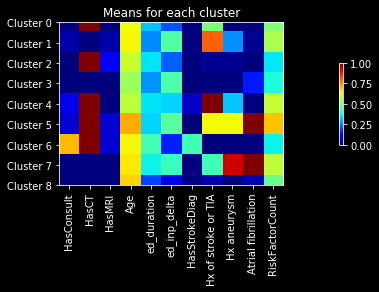

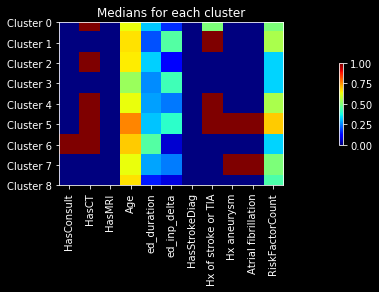

In [22]:
cluster_df = cluster_umap.run_clustering_on_umap(embedding, 9, mnm_feature_vec, nomod_mod_label_df)

    MOD  NoMOD  Unlabeled
0   4.0    1.0        2.0
1   1.0    6.0        7.0
2   1.0    1.0        3.0
3   6.0    9.0       20.0
4   6.0    8.0       17.0
5  12.0    3.0       13.0
6   1.0    6.0        7.0
7   7.0   10.0        9.0


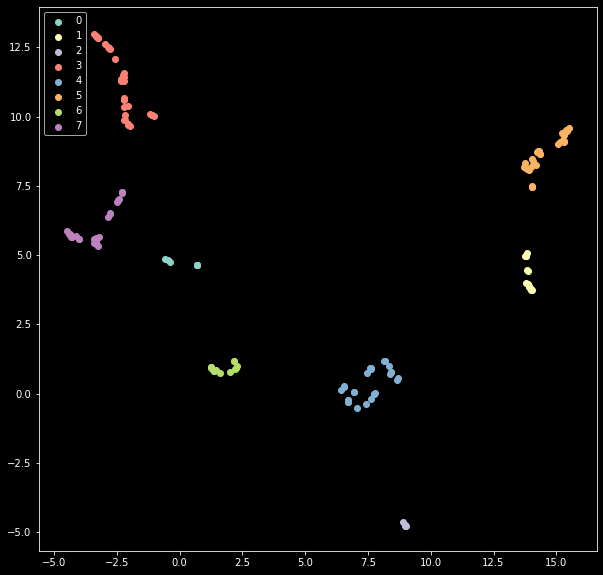

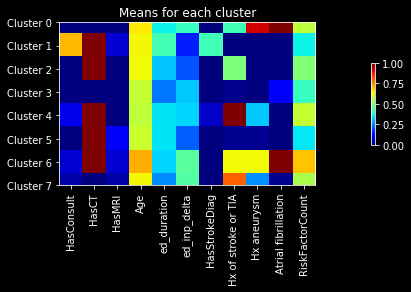

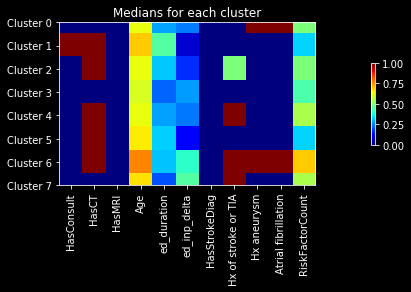

In [54]:
cluster_df = cluster_umap.run_clustering_on_umap(embedding, 8, mnm_feature_vec, nomod_mod_label_df)

[0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]


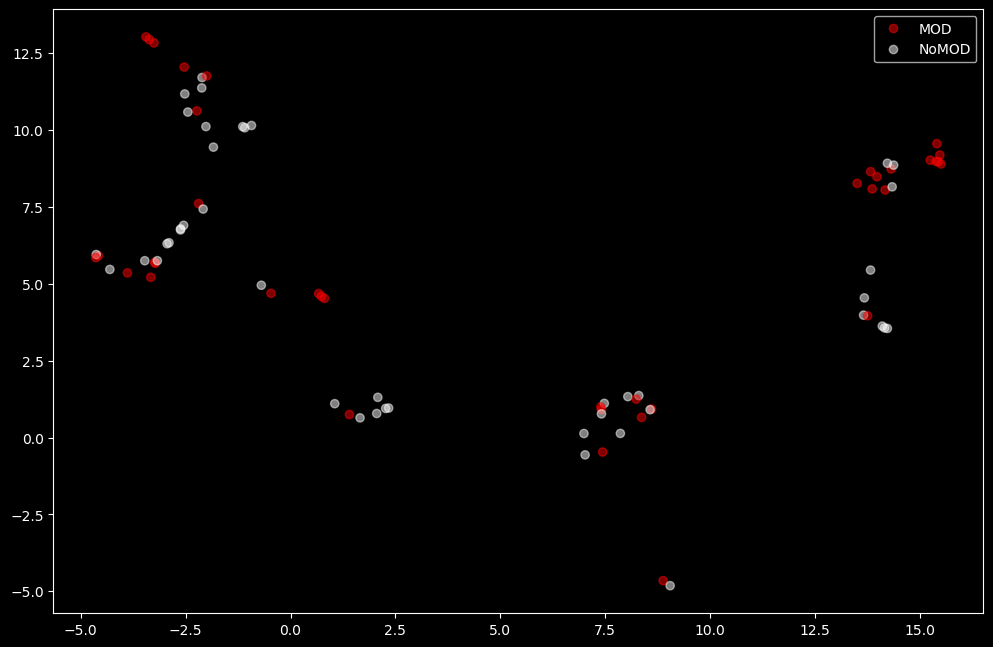

In [77]:
no_white_vecs = mnm_feature_vec.merge(nomod_mod_label_df)
no_white_vecs.drop(labels="Label", inplace=True, axis=1)
no_white_vecs.reset_index(inplace=True, drop=True)
no_white_embedding = util.UMAPPlotNoFit(reducer, no_white_vecs, label_map)


    MOD  NoMOD  Unlabeled
0   4.0    1.0        0.0
1   1.0    6.0        0.0
2   1.0    6.0        0.0
3   6.0    8.0        0.0
4  12.0    3.0        0.0
5   7.0   10.0        0.0
6   5.0    3.0        0.0
7   1.0    6.0        0.0
8   1.0    1.0        0.0


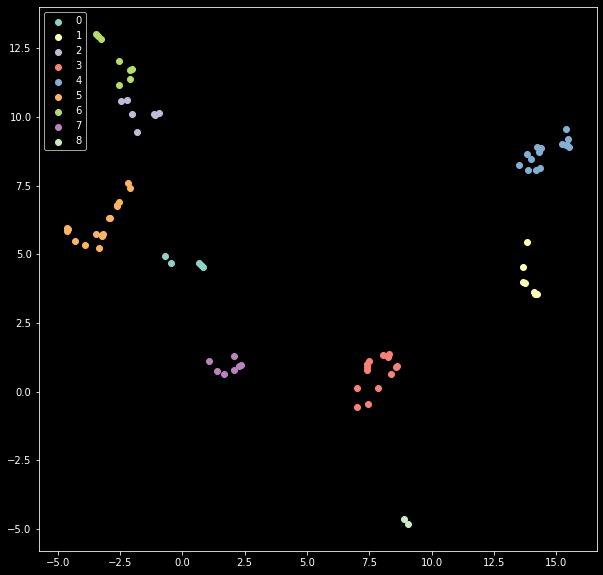

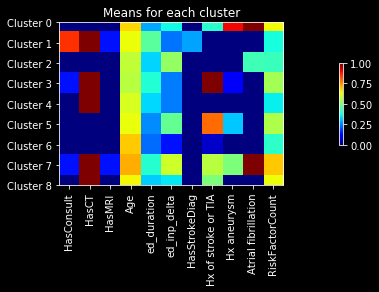

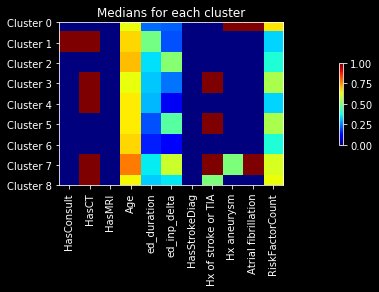

In [150]:
cluster_df = cluster_umap.run_clustering_on_umap(no_white_embedding, 9, no_white_vecs, nomod_mod_label_df)

In [ ]:
# cluster 2 in presentation
cluster_df[cluster_df.cluster == 3].PatientSSN.to_numpy()

In [ ]:
# cluster 3 in presentation
cluster_df[cluster_df.cluster == 6].PatientSSN.to_numpy()

In [ ]:
# cluster 4 in presentation
cluster_df[cluster_df.cluster == 5].PatientSSN.to_numpy()

    MOD  NoMOD  Unlabeled
0   1.0    6.0        0.0
1   1.0    6.0        0.0
2   6.0    4.0        0.0
3   6.0    8.0        0.0
4   6.0    3.0        0.0
5   1.0    6.0        0.0
6   4.0    1.0        0.0
7   1.0    1.0        0.0
8   5.0    3.0        0.0
9   6.0    0.0        0.0
10  1.0    6.0        0.0


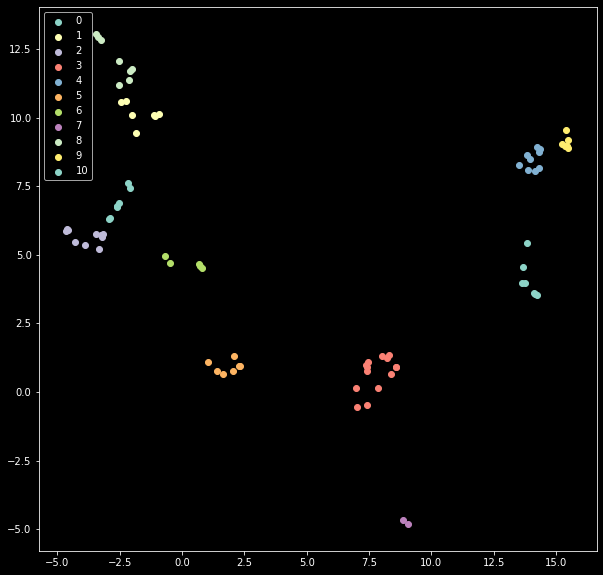

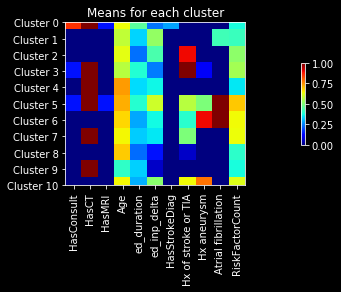

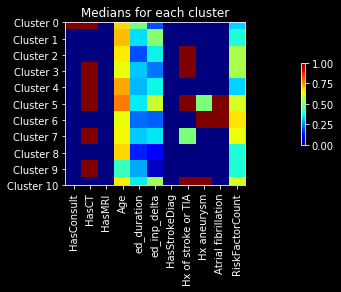

In [149]:
cluster_df = cluster_umap.run_clustering_on_umap(no_white_embedding, 11, no_white_vecs, nomod_mod_label_df)

In [ ]:
cluster_df[cluster_df.cluster == 3]

In [ ]:
mnm_feature_vec[mnm_feature_vec.HasStrokeDiag == 1]

In [95]:
diag_df = util.findERDiagnosis(icd_df, cohort_df)

In [116]:
diag_df[diag_df.PatientSSN == 123].to_csv("123.csv")

In [ ]:
diag_df[diag_df.PatientSSN == 123]

In [ ]:
diag_df[diag_df.PatientSSN == 123]

In [ ]:
cohort_df[cohort_df.patientSSN == 123]

In [ ]:
cluster_df[cluster_df.Label == "Unlabeled"].sample(n=10)

In [ ]:
util.UMAPClosestPairs(labeled_mnm_feature_vec, embedding)

# Train Test Split

In [23]:
# machine learning
from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFECV, chi2, mutual_info_classif

In [24]:
# seed
RANDOM_STATE_SEED = 42
# train-test-split test size
TEST_SIZE = 0.15
# logistic regression model constants
LOGISTIC_REGRESSION_ITER = 10000

In [168]:
labeled_df, unlabeled_df, X_cols, y_col = util.makeDataset(mnm_feature_vec, nomod_mod_label_df)

In [169]:
X_train, X_test, y_train, y_test = train_test_split(labeled_df[X_cols], labeled_df[y_col], test_size=TEST_SIZE, random_state=RANDOM_STATE_SEED)

# Pseudo Labeling

In [132]:
# create pseudo labeler based on the number of clusters previously estimated
pseudo_labeler = cluster_umap.UMAPLabeler(reducer, 9)

In [27]:
# Pseudo label the train set and unlabeled set. (Don't pass in SSNs)
pX, py, pw = pseudo_label.pseudo_label_dataset(pseudo_labeler, X_train, y_train, unlabeled_df[X_cols])

# Logistic Regression

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best penalty: l2
Best C: 0.2782559402207126
Best solver: saga
[[6 1]
 [2 4]]
              precision    recall  f1-score   support

         0.0       0.75      0.86      0.80         7
         1.0       0.80      0.67      0.73         6

    accuracy                           0.77        13
   macro avg       0.78      0.76      0.76        13
weighted avg       0.77      0.77      0.77        13

[[34  3]
 [19 13]]
              precision    recall  f1-score   support

         0.0       0.64      0.92      0.76        37
         1.0       0.81      0.41      0.54        32

    accuracy                           0.68        69
   macro avg       0.73      0.66      0.65        69
weighted avg       0.72      0.68      0.66        69



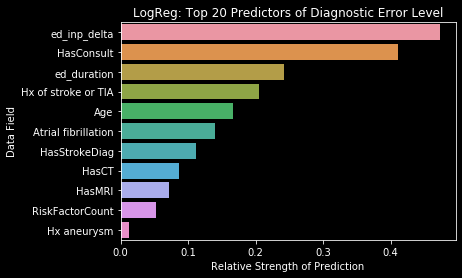

In [28]:
#
hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-5, 5, 10)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True, False]
}

best_model_log = eval_util.runLogRegWithDataset(hyperparameter_grid_log, X_cols, X_train, X_test, y_train, y_test)

Best penalty: l1
Best C: 0.1
Best solver: liblinear
[[7 0]
 [6 0]]
              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70         7
         1.0       0.00      0.00      0.00         6

    accuracy                           0.54        13
   macro avg       0.27      0.50      0.35        13
weighted avg       0.29      0.54      0.38        13

[[112   0]
 [112   0]]
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       112
         1.0       0.00      0.00      0.00       112

    accuracy                           0.50       224
   macro avg       0.25      0.50      0.33       224
weighted avg       0.25      0.50      0.33       224



C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


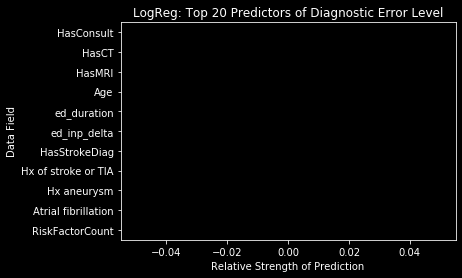

In [29]:
# run logistic regression on pseudo-labeled data
hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-1, 10, 10)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True, False]
}

best_model_log = eval_util.runLogRegWithDataset(hyperparameter_grid_log, X_cols, pX, X_test, py, y_test, pw)

# KNN

In [177]:
knn = cluster.KNNClusterUMAPClassifier(umap.UMAP(metric="correlation", min_dist=0, n_neighbors=5), n_neighbors=3)

In [178]:
knn.fit(X_train, y_train)

KNNClusterUMAPClassifier(algorithm=None, metric=None, n_neighbors=3, p=None,
                         umap_reducer=None)

In [179]:
knn.predict_proba(X_test)

array([0.45454545, 0.76923077, 0.41666667, 0.76923077, 0.45454545,
       0.45454545, 0.45454545, 0.41666667, 0.33333333, 0.76923077,
       0.45454545, 0.5       , 0.38636364])

In [172]:
y_test

63     1.0
1      1.0
49     0.0
65     0.0
43     0.0
60     0.0
22     0.0
111    1.0
11     0.0
26     1.0
103    1.0
68     1.0
134    0.0
Name: Label, dtype: float64

# Neural Net

In [31]:
nn_X_train = X_train.copy()

In [32]:
nn_X_train.shape

(69, 11)

In [33]:
len(nn_X_train.columns)

11

In [34]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(nn_X_train.columns),)),
#     tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

In [35]:
nn_model.compile(optimizer="adam",
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy', tf.keras.metrics.AUC()])
#                 metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [36]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 44        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = nn_model.fit(nn_X_train.to_numpy(), y_train.to_numpy(), epochs=200)

Train on 69 samples
Epoch 1/200
69/69 [==============================] - 2s 28ms/sample - loss: 0.7002 - accuracy: 0.5362 - auc: 0.5701
Epoch 2/200
69/69 [==============================] - 0s 453us/sample - loss: 0.6985 - accuracy: 0.5362 - auc: 0.5752
Epoch 3/200
69/69 [==============================] - 0s 2ms/sample - loss: 0.6970 - accuracy: 0.5362 - auc: 0.5747
Epoch 4/200
69/69 [==============================] - 0s 3ms/sample - loss: 0.6956 - accuracy: 0.5362 - auc: 0.5845
Epoch 5/200
69/69 [==============================] - 0s 2ms/sample - loss: 0.6948 - accuracy: 0.5362 - auc: 0.5861
Epoch 6/200
69/69 [==============================] - 0s 2ms/sample - loss: 0.6939 - accuracy: 0.5362 - auc: 0.5849
Epoch 7/200
69/69 [==============================] - 0s 3ms/sample - loss: 0.6929 - accuracy: 0.5362 - auc: 0.5933
Epoch 8/200
69/69 [==============================] - 0s 217us/sample - loss: 0.6922 - accuracy: 0.5362 - auc: 0.5916
Epoch 9/200
69/69 [==============================] - 0s

69/69 [==============================] - 0s 1ms/sample - loss: 0.6454 - accuracy: 0.6087 - auc: 0.7525
Epoch 142/200
69/69 [==============================] - 0s 3ms/sample - loss: 0.6450 - accuracy: 0.6087 - auc: 0.7538
Epoch 143/200
69/69 [==============================] - 0s 3ms/sample - loss: 0.6445 - accuracy: 0.6087 - auc: 0.7534
Epoch 144/200
69/69 [==============================] - 0s 1ms/sample - loss: 0.6441 - accuracy: 0.6087 - auc: 0.7508
Epoch 145/200
69/69 [==============================] - 0s 3ms/sample - loss: 0.6439 - accuracy: 0.6087 - auc: 0.7521
Epoch 146/200
69/69 [==============================] - 0s 3ms/sample - loss: 0.6436 - accuracy: 0.6087 - auc: 0.7513
Epoch 147/200
69/69 [==============================] - 0s 1ms/sample - loss: 0.6432 - accuracy: 0.6087 - auc: 0.7542
Epoch 148/200
69/69 [==============================] - 0s 2ms/sample - loss: 0.6430 - accuracy: 0.6087 - auc: 0.7546
Epoch 149/200
69/69 [==============================] - 0s 3ms/sample - loss: 0

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auc'])

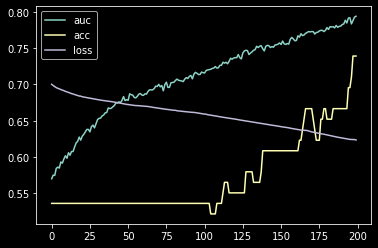

In [40]:
plt.plot(history.history['auc'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['auc', 'acc', 'loss'], loc='upper left')
plt.show()

In [41]:
nn_X_test = X_test.copy()
predictions = nn_model.predict(nn_X_test.to_numpy())

In [42]:
(predictions > 0.5).astype(int)

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0]])

In [43]:
y_test

63     1.0
1      1.0
49     0.0
65     0.0
43     0.0
60     0.0
22     0.0
111    1.0
11     0.0
26     1.0
103    1.0
68     1.0
134    0.0
Name: Label, dtype: float64

In [44]:
nn_model.evaluate(nn_X_test.to_numpy(), y_test.to_numpy())

13/13 [==============================] - 1s 77ms/sample - loss: 0.5796 - accuracy: 0.8462 - auc: 0.9167


[0.5795639157295227, 0.84615386, 0.9166667]

In [45]:
print(sklearn.metrics.classification_report(y_test.to_numpy(), (predictions > 0.5).astype(int)))

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88         7
         1.0       1.00      0.67      0.80         6

    accuracy                           0.85        13
   macro avg       0.89      0.83      0.84        13
weighted avg       0.88      0.85      0.84        13



In [46]:
predictions

array([[0.47049147],
       [0.53700775],
       [0.4261101 ],
       [0.18694477],
       [0.42199045],
       [0.4701308 ],
       [0.4816844 ],
       [0.5112919 ],
       [0.32636297],
       [0.5154757 ],
       [0.50839126],
       [0.46571544],
       [0.32066962]], dtype=float32)

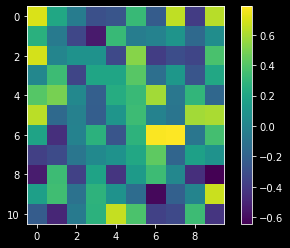

In [47]:
plt.imshow(nn_model.layers[0].get_weights()[0])
plt.colorbar()

In [ ]:
nn_X_train

In [49]:
tf.keras.utils.plot_model(nn_model, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


### NN + Pseudo Labeling

In [50]:
# sanity check: first half of py are 1s
py

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [51]:
# add bias term, and only keep first half of pX pw
# this is because we only train with the probability of being label 1
n = int(pX.shape[0]/2)
nn_pX = pX.iloc[:n, :].copy()
nn_py = pw[:n]

In [52]:
nn_py = np.stack([1- nn_py, nn_py], -1)

In [53]:
nn_py

array([[0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.

In [54]:
nn_pmodel = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(nn_pX.columns),)),
#     tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(2, activation="softmax"),
])

In [55]:
nn_pmodel.compile(optimizer="adam",
                loss=tf.keras.losses.KLDivergence(),
                metrics=["accuracy"])
#                 metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [56]:
nn_pmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                120       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 44        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
Total params: 174
Trainable params: 174
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = nn_pmodel.fit(nn_pX.to_numpy(), nn_py, epochs=200)

Train on 112 samples
Epoch 1/200
112/112 [==============================] - 1s 11ms/sample - loss: 0.5035 - accuracy: 0.6161
Epoch 2/200
112/112 [==============================] - 0s 952us/sample - loss: 0.5015 - accuracy: 0.5804
Epoch 3/200
112/112 [==============================] - 0s 2ms/sample - loss: 0.4998 - accuracy: 0.6518
Epoch 4/200
112/112 [==============================] - 0s 1ms/sample - loss: 0.4982 - accuracy: 0.5357
Epoch 5/200
112/112 [==============================] - 0s 857us/sample - loss: 0.4968 - accuracy: 0.5536
Epoch 6/200
112/112 [==============================] - 0s 3ms/sample - loss: 0.4959 - accuracy: 0.5714
Epoch 7/200
112/112 [==============================] - 0s 964us/sample - loss: 0.4947 - accuracy: 0.5804
Epoch 8/200
112/112 [==============================] - 0s 1ms/sample - loss: 0.4942 - accuracy: 0.5804
Epoch 9/200
112/112 [==============================] - 0s 4ms/sample - loss: 0.4933 - accuracy: 0.5804
Epoch 10/200
112/112 [=======================

112/112 [==============================] - 0s 1ms/sample - loss: 0.3762 - accuracy: 0.8125
Epoch 157/200
112/112 [==============================] - 0s 896us/sample - loss: 0.3756 - accuracy: 0.8125
Epoch 158/200
112/112 [==============================] - 0s 277us/sample - loss: 0.3752 - accuracy: 0.8125
Epoch 159/200
112/112 [==============================] - 0s 2ms/sample - loss: 0.3747 - accuracy: 0.8125
Epoch 160/200
112/112 [==============================] - 0s 2ms/sample - loss: 0.3742 - accuracy: 0.8125
Epoch 161/200
112/112 [==============================] - 0s 313us/sample - loss: 0.3738 - accuracy: 0.8125
Epoch 162/200
112/112 [==============================] - 0s 1ms/sample - loss: 0.3734 - accuracy: 0.8125
Epoch 163/200
112/112 [==============================] - 0s 813us/sample - loss: 0.3729 - accuracy: 0.8125
Epoch 164/200
112/112 [==============================] - 0s 3ms/sample - loss: 0.3726 - accuracy: 0.8125
Epoch 165/200
112/112 [==============================] - 0s 1

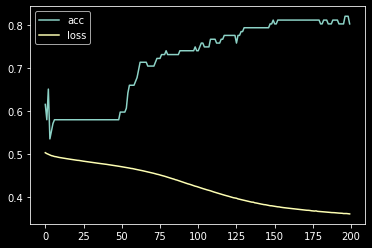

In [58]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['acc', 'loss'], loc='upper left')
plt.show()

In [59]:
predictions2 = nn_pmodel.predict(nn_X_test.to_numpy())

In [60]:
predictions2

array([[0.5815574 , 0.41844258],
       [0.22028592, 0.77971405],
       [0.7215429 , 0.2784571 ],
       [0.5080351 , 0.49196485],
       [0.7118186 , 0.28818142],
       [0.55923384, 0.4407662 ],
       [0.8135479 , 0.18645208],
       [0.4654428 , 0.5345572 ],
       [0.8186421 , 0.18135794],
       [0.30227005, 0.69773   ],
       [0.45311463, 0.5468854 ],
       [0.62954664, 0.3704534 ],
       [0.6925939 , 0.30740616]], dtype=float32)

In [63]:
nn_y_test = y_test.to_numpy()
nn_y_test = np.stack([1- nn_y_test, nn_y_test], -1)
nn_pmodel.evaluate(nn_X_test.to_numpy(), nn_y_test)

13/13 [==============================] - 0s 18ms/sample - loss: 0.4924 - accuracy: 0.8462


[0.4924050569534302, 0.84615386]

In [64]:
print(sklearn.metrics.classification_report(y_test.to_numpy(), np.argmax(predictions2, axis=1)))

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88         7
         1.0       1.00      0.67      0.80         6

    accuracy                           0.85        13
   macro avg       0.89      0.83      0.84        13
weighted avg       0.88      0.85      0.84        13



# Repeated Runs

In [83]:
# useful helpers for aggregating results

import copy
import json
def aggregateListDict(l):
    agg_d = dict()
    for k in l[0].keys():
        agg_d[k] = []
        
    for d in l:
        for k, v in d.items():
            agg_d[k].append(v)
    
    for k, v in agg_d.items():
        if isinstance(v[0], dict):
            agg_d[k] = aggregateListDict(v)
    return agg_d

def mapDictList(d, f):
    d = copy.deepcopy(d)
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = mapDictList(v, f)
        else:
            d[k] = f(v)
    return d

def calcMeanStdMinMax(x):
    X = np.array(x)
    return (np.mean(X), np.sqrt(np.var(X)), float(np.min(X)), float(np.max(X)))

In [92]:
def runLogRegCV(random_state, kfold=5):
    hyper_params = {
#         'penalty': ['l1', 'l2']
        'penalty': ['l2']
        ,'C': np.logspace(-5, 5, 10)
        ,'solver': ['liblinear','saga']
    }
    models = []
    confusion_matrices = []
    results = []
    
    labeled_df, unlabeled_df, X_cols, y_col = util.makeDataset(mnm_feature_vec, nomod_mod_label_df)
    
    skf = sklearn.model_selection.StratifiedKFold(n_splits=kfold, shuffle=True, random_state=random_state)
    
    for train_index, test_index in skf.split(labeled_df[X_cols], labeled_df[y_col]):
        X_train, X_test = labeled_df[X_cols].iloc[train_index], labeled_df[X_cols].iloc[test_index]
        y_train, y_test = labeled_df[y_col].iloc[train_index], labeled_df[y_col].iloc[test_index]
        
        grid_search = GridSearchCV(
            estimator = LogisticRegression(max_iter=LOGISTIC_REGRESSION_ITER, random_state=random_state, class_weight='balanced')
            ,param_grid = hyper_params
            ,scoring = None
            ,n_jobs = 1
            ,cv = 5
            ,verbose = 0
            ,return_train_score = False
        )

        best_model = grid_search.fit(X_train, y_train)
        
        best_params = dict()

        for k in hyper_params.keys():
            best_params[k] = best_model.best_estimator_.get_params()[k]
        
        predictions = best_model.predict(X_test)
        confusion_matrices.append(metrics.confusion_matrix(y_test, predictions))
        result = metrics.classification_report(y_test, predictions, output_dict=True)
        result["best_params"] = best_params
        
        result["auc"] = metrics.roc_auc_score(y_test.to_numpy(), best_model.predict_proba(X_test)[:,1])
        
        models.append(best_model)
        results.append(result)
    return models, results, confusion_matrices


In [93]:
lr_models, lr_results, lr_confusion_matrices = runLogRegCV(RANDOM_STATE_SEED, 8)

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are un

In [94]:
lr_results

[{'0.0': {'precision': 1.0,
   'recall': 0.6666666666666666,
   'f1-score': 0.8,
   'support': 6},
  '1.0': {'precision': 0.7142857142857143,
   'recall': 1.0,
   'f1-score': 0.8333333333333333,
   'support': 5},
  'accuracy': 0.8181818181818182,
  'macro avg': {'precision': 0.8571428571428572,
   'recall': 0.8333333333333333,
   'f1-score': 0.8166666666666667,
   'support': 11},
  'weighted avg': {'precision': 0.8701298701298701,
   'recall': 0.8181818181818182,
   'f1-score': 0.8151515151515152,
   'support': 11},
  'best_params': {'penalty': 'l2',
   'C': 599.4842503189421,
   'solver': 'liblinear'},
  'auc': 0.9333333333333333},
 {'0.0': {'precision': 0.75, 'recall': 0.5, 'f1-score': 0.6, 'support': 6},
  '1.0': {'precision': 0.5714285714285714,
   'recall': 0.8,
   'f1-score': 0.6666666666666666,
   'support': 5},
  'accuracy': 0.6363636363636364,
  'macro avg': {'precision': 0.6607142857142857,
   'recall': 0.65,
   'f1-score': 0.6333333333333333,
   'support': 11},
  'weighted a

In [95]:
lr_results_agg = aggregateListDict(lr_results)
lr_results_agg.pop("best_params")
print("(Averages, Std, Min, Max):")
print(json.dumps(mapDictList(lr_results_agg, calcMeanStdMinMax), indent=4))

(Averages, Std, Min, Max):
{
    "0.0": {
        "precision": [
            0.6317234848484848,
            0.3180330725324068,
            0.0,
            1.0
        ],
        "recall": [
            0.6125,
            0.31707758426676025,
            0.0,
            1.0
        ],
        "f1-score": [
            0.5948058069381599,
            0.26768577658735426,
            0.0,
            0.8000000000000002
        ],
        "support": [
            5.5,
            0.5,
            5.0,
            6.0
        ]
    },
    "1.0": {
        "precision": [
            0.540625,
            0.30656578627396686,
            0.0,
            1.0
        ],
        "recall": [
            0.6125,
            0.34708608442287053,
            0.0,
            1.0
        ],
        "f1-score": [
            0.544345238095238,
            0.28325563535491655,
            0.0,
            0.8333333333333333
        ],
        "support": [
            4.75,
            0.433012701

In [96]:
lr_models, lr_results, lr_confusion_matrices = runLogRegCV(RANDOM_STATE_SEED, 5)

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [97]:
lr_results_agg = aggregateListDict(lr_results)
lr_results_agg.pop("best_params")
print("(Averages, Std, Min, Max):")
print(json.dumps(mapDictList(lr_results_agg, calcMeanStdMinMax), indent=4))

(Averages, Std, Min, Max):
{
    "0.0": {
        "precision": [
            0.6816399286987522,
            0.1834190626393023,
            0.5294117647058824,
            1.0
        ],
        "recall": [
            0.7305555555555555,
            0.17821127702606043,
            0.5555555555555556,
            1.0
        ],
        "f1-score": [
            0.6771356747827337,
            0.09356610443304782,
            0.5555555555555556,
            0.823529411764706
        ],
        "support": [
            8.8,
            0.4,
            8.0,
            9.0
        ]
    },
    "1.0": {
        "precision": [
            0.49393939393939396,
            0.27550771230741106,
            0.0,
            0.8333333333333334
        ],
        "recall": [
            0.5178571428571429,
            0.3346487650034994,
            0.0,
            1.0
        ],
        "f1-score": [
            0.49511599511599513,
            0.28447441861283196,
            0.0,
         

In [98]:
def runNLogRegCV(n, random_state, kfold=5):
    models, results, confusion_matrices = [], [], []
    for i in range(n):
        m, r, c = runLogRegCV(random_state + i, kfold)
        models += m
        results += r
        confusion_matrices += c
    return models, results, confusion_matrices

In [99]:
lr_ncv_models, lr_ncv_results, lr_ncv_confusion_matrices = runNLogRegCV(20, RANDOM_STATE_SEED, 8)
lr_ncv_results_agg = aggregateListDict(lr_ncv_results)
lr_ncv_results_agg.pop("best_params")
print("(Averages, Std, Min, Max):")
print(json.dumps(mapDictList(lr_ncv_results_agg, calcMeanStdMinMax), indent=4))

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are un

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are un

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are un

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are un

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are un

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are un

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are un

(Averages, Std, Min, Max):
{
    "0.0": {
        "precision": [
            0.6165593434343435,
            0.16050709861248694,
            0.0,
            1.0
        ],
        "recall": [
            0.7108333333333334,
            0.266759098563979,
            0.0,
            1.0
        ],
        "f1-score": [
            0.636622280905369,
            0.17293878407480381,
            0.0,
            0.923076923076923
        ],
        "support": [
            5.5,
            0.5,
            5.0,
            6.0
        ]
    },
    "1.0": {
        "precision": [
            0.6239980158730158,
            0.3001823541836845,
            0.0,
            1.0
        ],
        "recall": [
            0.47937499999999994,
            0.25934939632665427,
            0.0,
            1.0
        ],
        "f1-score": [
            0.49664033882783887,
            0.21420534912633019,
            0.0,
            0.888888888888889
        ],
        "support": [
         

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [100]:
lr_ncv_models5, lr_ncv_results5, lr_ncv_confusion_matrices5 = runNLogRegCV(20, RANDOM_STATE_SEED, 5)
lr_ncv_results_agg5 = aggregateListDict(lr_ncv_results5)
lr_ncv_results_agg5.pop("best_params")
print("(Averages, Std, Min, Max):")
print(json.dumps(mapDictList(lr_ncv_results_agg5, calcMeanStdMinMax), indent=4))

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppD

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VHAHOUYuM\AppD

(Averages, Std, Min, Max):
{
    "0.0": {
        "precision": [
            0.6184062179650414,
            0.1126562360530537,
            0.25,
            1.0
        ],
        "recall": [
            0.7208333333333333,
            0.23806787210456404,
            0.125,
            1.0
        ],
        "f1-score": [
            0.6470949089692258,
            0.13889947028411415,
            0.16666666666666666,
            0.888888888888889
        ],
        "support": [
            8.8,
            0.4,
            8.0,
            9.0
        ]
    },
    "1.0": {
        "precision": [
            0.6465454545454545,
            0.2579623154891164,
            0.0,
            1.0
        ],
        "recall": [
            0.47375,
            0.23146129343184546,
            0.0,
            1.0
        ],
        "f1-score": [
            0.49852241016637294,
            0.1870907304553211,
            0.0,
            0.888888888888889
        ],
        "support": [
 

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [198]:
np.sort(np.array(aggregateListDict(lr_ncv_results5)["best_params"]["C"]))

array([1.00000000e-05, 1.00000000e-05, 1.66810054e-03, 1.66810054e-03,
       1.66810054e-03, 1.66810054e-03, 1.66810054e-03, 1.66810054e-03,
       2.15443469e-02, 2.15443469e-02, 2.15443469e-02, 2.15443469e-02,
       2.15443469e-02, 2.15443469e-02, 2.15443469e-02, 2.15443469e-02,
       2.15443469e-02, 2.15443469e-02, 2.15443469e-02, 2.15443469e-02,
       2.15443469e-02, 2.15443469e-02, 2.15443469e-02, 2.15443469e-02,
       2.15443469e-02, 2.15443469e-02, 2.15443469e-02, 2.15443469e-02,
       2.15443469e-02, 2.15443469e-02, 2.15443469e-02, 2.15443469e-02,
       2.15443469e-02, 2.15443469e-02, 2.15443469e-02, 2.15443469e-02,
       2.15443469e-02, 2.15443469e-02, 2.15443469e-02, 2.15443469e-02,
       2.15443469e-02, 2.15443469e-02, 2.15443469e-02, 2.15443469e-02,
       2.15443469e-02, 2.78255940e-01, 2.78255940e-01, 2.78255940e-01,
       2.78255940e-01, 2.78255940e-01, 2.78255940e-01, 2.78255940e-01,
       2.78255940e-01, 2.78255940e-01, 2.78255940e-01, 2.78255940e-01,
      

In [82]:
def runLogRegEval(times):
    hyper_params = {
        'penalty': ['l1', 'l2']
        ,'C': np.logspace(-5, 5, 10)
        ,'solver': ['liblinear','saga']
    }
    models = []
    confusion_matrices = []
    results = []
    for i in range(times):
        labeled_df, unlabeled_df, X_cols, y_col = util.makeDataset(mnm_feature_vec, nomod_mod_label_df)
        X_train, X_test, y_train, y_test = train_test_split(labeled_df[X_cols], 
                                                            labeled_df[y_col], 
                                                            test_size=TEST_SIZE, 
                                                            random_state=RANDOM_STATE_SEED + i)

        grid_search = GridSearchCV(
            estimator = LogisticRegression(max_iter=LOGISTIC_REGRESSION_ITER, random_state=RANDOM_STATE_SEED, class_weight='balanced')
            ,param_grid = hyper_params
            ,scoring = None
            ,n_jobs = 1
            ,cv = 5
            ,verbose = 0
            ,return_train_score = False
        )

        best_model = grid_search.fit(X_train, y_train)
        
        best_params = dict()

        for k in hyper_params.keys():
            best_params[k] = best_model.best_estimator_.get_params()[k]
        
        predictions = best_model.predict(X_test)
        confusion_matrices.append(metrics.confusion_matrix(y_test, predictions))
        result = metrics.classification_report(y_test, predictions, output_dict=True)
        result["best_params"] = best_params
        
        models.append(best_model)
        results.append(result)
    return models, results, confusion_matrices


In [83]:
lr_models, lr_results, lr_confusion_matrices = runLogRegEval(20)

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are un

In [105]:
AUC = tf.keras.metrics.AUC()

In [106]:
AUC.name

'auc'

In [121]:
AUC.reset_states()

In [129]:
def trainNN(X_train, y_train, unlabeled_df, epochs=200):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(len(X_train.columns),)),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(4, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(optimizer="adam",
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy', AUC])
    history = model.fit(X_train.to_numpy(dtype="float32"), y_train.to_numpy(dtype="float32"), epochs=epochs, verbose=0)
    
    print(model.evaluate(X_train.to_numpy(dtype="float32"), y_train.to_numpy(dtype="float32")))
    
    plt.plot(history.history[AUC.name])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])
    plt.legend(['auc', 'acc', 'loss'], loc='upper left')
    plt.show()
    
    return model

def evaluateNN(model, X_test, y_test):
    model.evaluate(X_test.to_numpy(dtype="float32"), y_test.to_numpy(dtype="float32"))
    prediction = model.predict(X_test.to_numpy(dtype="float32"))
    result = sklearn.metrics.classification_report(y_test.to_numpy(), 
                                                   (prediction > 0.5).astype(int), output_dict=True)
    result["auc"] = sklearn.metrics.roc_auc_score(y_test.to_numpy(), prediction)
#     AUC.reset_states()
#     AUC.update_state(y_test.to_numpy(), prediction[:,0])
#     print(AUC.result())
#     AUC.reset_states()
    return result

In [130]:
def trainPNN(X_train, y_train, unlabeled_df, epochs=200):
    pX, py, pw = pseudo_label.pseudo_label_dataset(pseudo_labeler, X_train, y_train, unlabeled_df)
    n = int(pX.shape[0]/2)
    X = pX.iloc[:n, :].to_numpy(dtype="float32")
    y = pw[:n].astype("float32")
    y = np.stack([1- y, y], -1)
    pmodel = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(len(pX.columns),)),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(4, activation="relu"),
        tf.keras.layers.Dense(2, activation="softmax"),
    ])
    pmodel.compile(optimizer="adam", loss=tf.keras.losses.KLDivergence(), metrics=["accuracy"])
    history = pmodel.fit(X, y, epochs=epochs, verbose=0)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])
    plt.legend(['acc', 'loss'], loc='upper left')
    plt.show()
    
    return pmodel

def evaluatePNN(model, X_test, y_test):
    nn_y_test = y_test.to_numpy(dtype="float32")
    nn_y_test = np.stack([1- nn_y_test, nn_y_test], -1)
    model.evaluate(X_test.to_numpy(dtype="float32"), nn_y_test)
    prediction = model.predict(X_test.to_numpy(dtype="float32"))
    result = sklearn.metrics.classification_report(y_test.to_numpy(), 
                                                   np.argmax(prediction, axis=1), output_dict=True)
    result["auc"] = sklearn.metrics.roc_auc_score(y_test.to_numpy(), np.argmax(prediction, axis=1))
    return result

In [116]:
def runNNEval(times, train_func, eval_func):
    models = []
    results = []
    for i in range(times):
        labeled_df, unlabeled_df, X_cols, y_col = util.makeDataset(mnm_feature_vec, nomod_mod_label_df)
        X_train, X_test, y_train, y_test = train_test_split(labeled_df[X_cols], 
                                                            labeled_df[y_col], 
                                                            test_size=TEST_SIZE, 
                                                            random_state=RANDOM_STATE_SEED + i)
        model = train_func(X_train, y_train, unlabeled_df[X_cols])
        models.append(model)
        results.append(eval_func(model, X_test, y_test))
    return models, results

In [180]:
def runClassifierEvalCV(times, train_func, eval_func, kfold=5):
    models = []
    results = []
    
    for i in range(times):
        labeled_df, unlabeled_df, X_cols, y_col = util.makeDataset(mnm_feature_vec, nomod_mod_label_df)
    
        skf = sklearn.model_selection.StratifiedKFold(n_splits=kfold, shuffle=True, random_state=RANDOM_STATE_SEED + i)
    
        for train_index, test_index in skf.split(labeled_df[X_cols], labeled_df[y_col]):
            X_train, X_test = labeled_df[X_cols].iloc[train_index], labeled_df[X_cols].iloc[test_index]
            y_train, y_test = labeled_df[y_col].iloc[train_index], labeled_df[y_col].iloc[test_index]

            model = train_func(X_train, y_train, unlabeled_df[X_cols])
            models.append(model)
            results.append(eval_func(model, X_test, y_test))
            
    return models, results

65/65 [==============================] - 0s 6ms/sample - loss: 0.6340 - accuracy: 0.6615 - auc: 0.7519
[0.634010611130641, 0.6615385, 0.7519048]


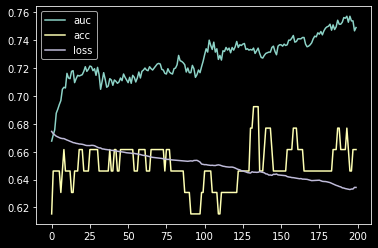

65/65 [==============================] - 1s 11ms/sample - loss: 0.5227 - accuracy: 0.8154 - auc: 0.8610
[0.5227011130406306, 0.8153846, 0.8609524]


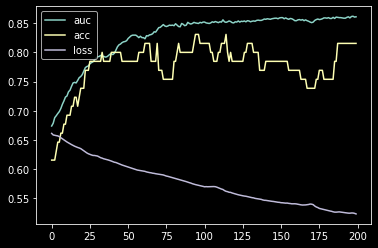

65/65 [==============================] - 0s 6ms/sample - loss: 0.6300 - accuracy: 0.7077 - auc: 0.8033
[0.6300296398309561, 0.7076923, 0.8033333]


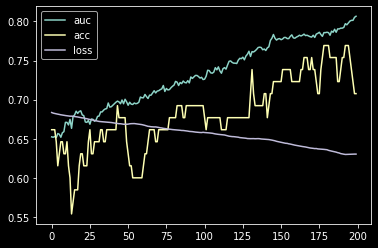

66/66 [==============================] - 0s 6ms/sample - loss: 0.5930 - accuracy: 0.6667 - auc: 0.7917
[0.5929589036739233, 0.6666667, 0.791705]


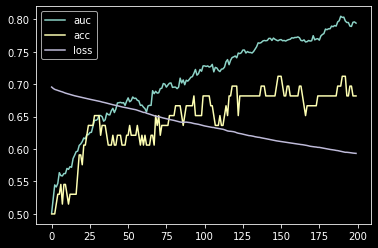

67/67 [==============================] - 0s 5ms/sample - loss: 0.5549 - accuracy: 0.7463 - auc: 0.8665
[0.5548741577276542, 0.74626863, 0.86648744]


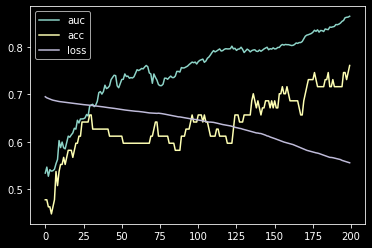

15/15 [==============================] - 0s 0s/sample - loss: 0.5613 - accuracy: 0.8000 - auc: 0.9286


In [138]:
nn_models, nn_results = runClassifierEvalCV(1, trainNN, evaluateNN)

In [139]:
for d in nn_results:
    print(d["auc"])

0.8194444444444444
0.4444444444444445
0.5972222222222223
0.5714285714285714
0.9285714285714286


69/69 [==============================] - 1s 13ms/sample - loss: 0.6407 - accuracy: 0.7246 - auc_1: 0.8501
[0.6407196452652199, 0.7246377, 0.8500845]


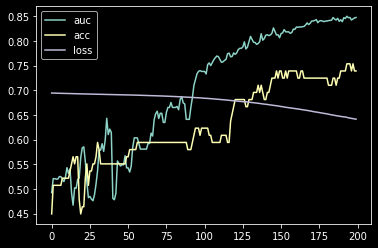

69/69 [==============================] - 1s 12ms/sample - loss: 0.6330 - accuracy: 0.7101 - auc_1: 0.8080
[0.6330011357431826, 0.71014494, 0.80798316]


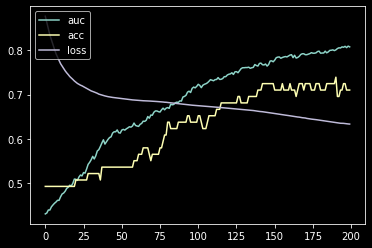

69/69 [==============================] - 1s 10ms/sample - loss: 0.5151 - accuracy: 0.7971 - auc_1: 0.8953
[0.5150810186413751, 0.79710144, 0.89529914]


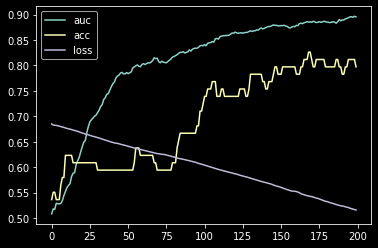

69/69 [==============================] - 1s 13ms/sample - loss: 0.5689 - accuracy: 0.7391 - auc_1: 0.8716
[0.5688711447992186, 0.73913044, 0.871633]


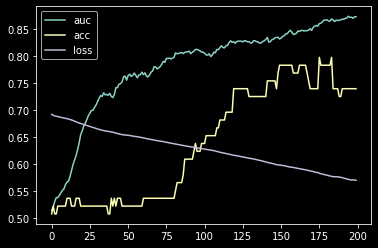

69/69 [==============================] - 1s 14ms/sample - loss: 0.6072 - accuracy: 0.6667 - auc_1: 0.7846
[0.6072243279305057, 0.6666667, 0.7846154]


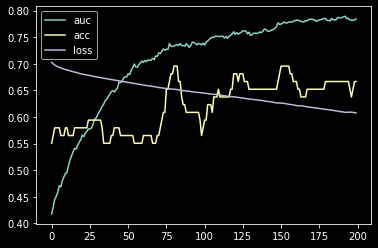

69/69 [==============================] - 1s 11ms/sample - loss: 0.4463 - accuracy: 0.7826 - auc_1: 0.9080
[0.44625064989794855, 0.7826087, 0.9079832]


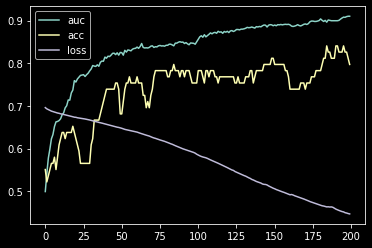

69/69 [==============================] - 1s 13ms/sample - loss: 0.5164 - accuracy: 0.7246 - auc_1: 0.8540
[0.5164388573688009, 0.7246377, 0.8539562]


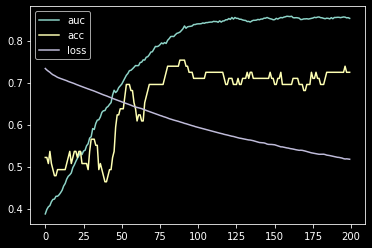

69/69 [==============================] - 1s 10ms/sample - loss: 0.4939 - accuracy: 0.8261 - auc_1: 0.8969
[0.493888091781865, 0.82608694, 0.89688545]


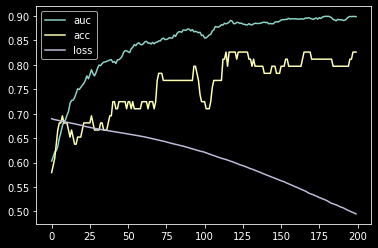

69/69 [==============================] - 1s 12ms/sample - loss: 0.5987 - accuracy: 0.7391 - auc_1: 0.8285
[0.5987108794675358, 0.73913044, 0.8285229]


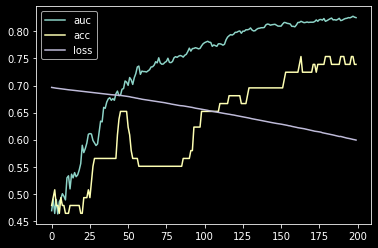

69/69 [==============================] - 1s 10ms/sample - loss: 0.5613 - accuracy: 0.7971 - auc_1: 0.8803
[0.5613141621368519, 0.79710144, 0.8803418]


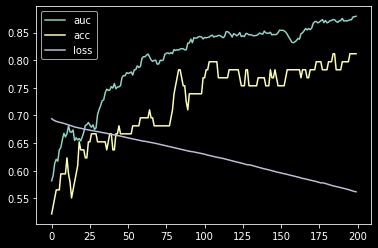

69/69 [==============================] - 1s 10ms/sample - loss: 0.6722 - accuracy: 0.6812 - auc_1: 0.6679
[0.6722491357637488, 0.68115944, 0.6679293]


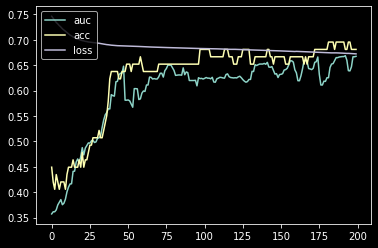

69/69 [==============================] - 1s 11ms/sample - loss: 0.6018 - accuracy: 0.7681 - auc_1: 0.8767
[0.6018115385718967, 0.76811594, 0.8767242]


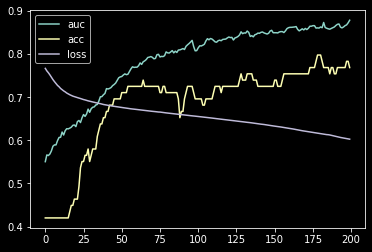

69/69 [==============================] - 1s 11ms/sample - loss: 0.6261 - accuracy: 0.6812 - auc_1: 0.8077
[0.6260512626689413, 0.68115944, 0.8076599]


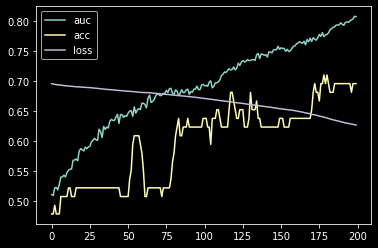

69/69 [==============================] - 1s 11ms/sample - loss: 0.5019 - accuracy: 0.7391 - auc_1: 0.8455
[0.5018668606661368, 0.73913044, 0.84553874]


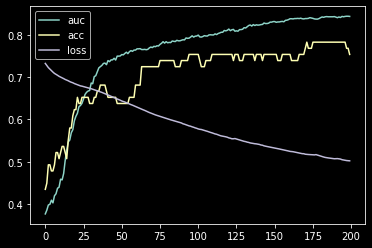

69/69 [==============================] - 1s 13ms/sample - loss: 0.4773 - accuracy: 0.7826 - auc_1: 0.8598
[0.477341796177021, 0.7826087, 0.85975605]


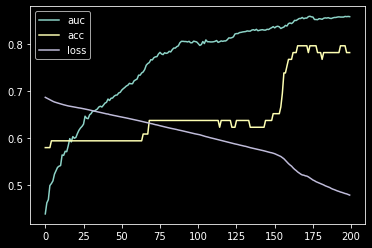

69/69 [==============================] - 1s 12ms/sample - loss: 0.5485 - accuracy: 0.7826 - auc_1: 0.8312
[0.5484741399253624, 0.7826087, 0.83119655]


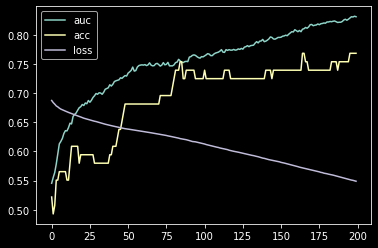

69/69 [==============================] - 1s 11ms/sample - loss: 0.6291 - accuracy: 0.6957 - auc_1: 0.8051
[0.6290879033613896, 0.6956522, 0.8051347]


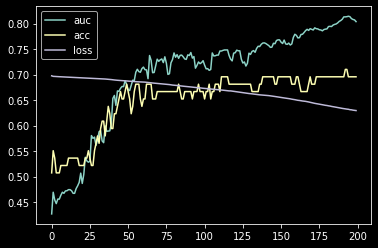

69/69 [==============================] - 1s 11ms/sample - loss: 0.5749 - accuracy: 0.7826 - auc_1: 0.8471
[0.574870404989823, 0.7826087, 0.84705883]


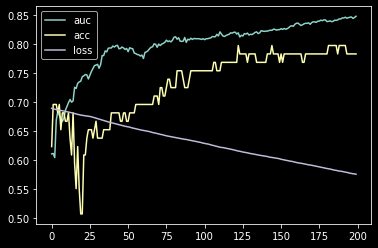

69/69 [==============================] - 1s 12ms/sample - loss: 0.6028 - accuracy: 0.6957 - auc_1: 0.8244
[0.6027560234069824, 0.6956522, 0.8243697]


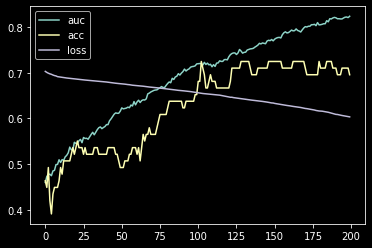

69/69 [==============================] - 1s 13ms/sample - loss: 0.4934 - accuracy: 0.7681 - auc_1: 0.8705
[0.4934146093285602, 0.76811594, 0.87054336]


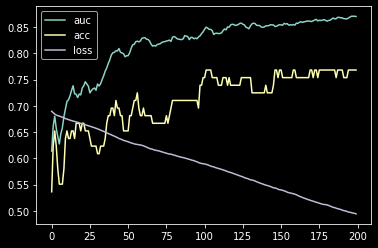

13/13 [==============================] - 0s 577us/sample - loss: 0.7984 - accuracy: 0.4615 - auc_1: 0.5000


In [71]:
nn_models, nn_results = runNNEval(20, trainNN, evaluateNN)

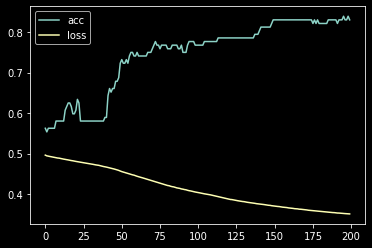

13/13 [==============================] - 0s 19ms/sample - loss: 0.4871 - accuracy: 0.7692


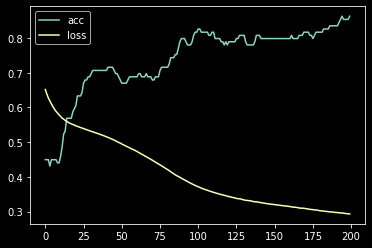

13/13 [==============================] - 0s 20ms/sample - loss: 0.6402 - accuracy: 0.6923


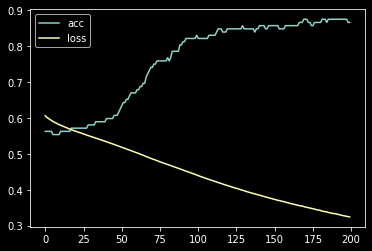

13/13 [==============================] - 0s 18ms/sample - loss: 1.0070 - accuracy: 0.4615


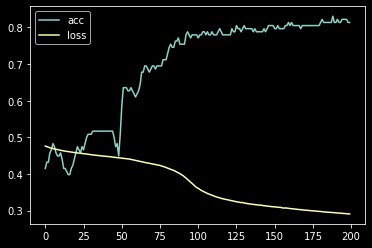

13/13 [==============================] - 0s 21ms/sample - loss: 1.2539 - accuracy: 0.1538


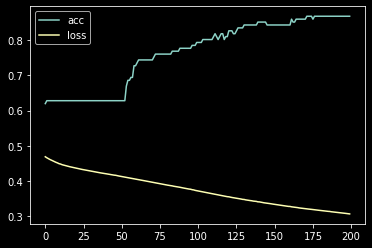

13/13 [==============================] - 0s 20ms/sample - loss: 0.7445 - accuracy: 0.6154


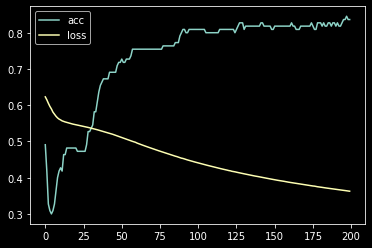

13/13 [==============================] - 0s 22ms/sample - loss: 0.8435 - accuracy: 0.3846


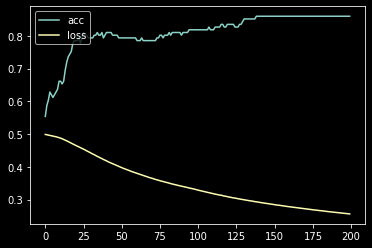

13/13 [==============================] - 0s 23ms/sample - loss: 0.7934 - accuracy: 0.5385


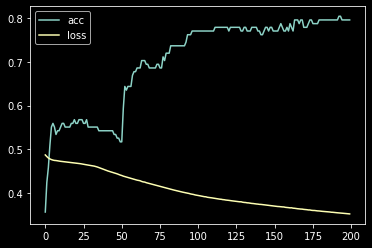

13/13 [==============================] - 0s 19ms/sample - loss: 0.6505 - accuracy: 0.6154


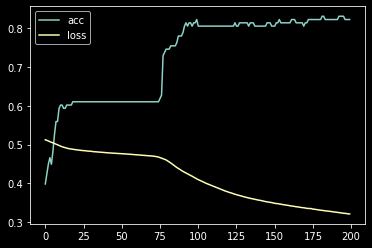

13/13 [==============================] - 0s 17ms/sample - loss: 0.9075 - accuracy: 0.4615


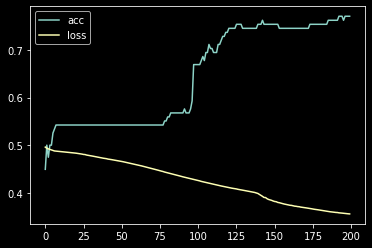

13/13 [==============================] - 0s 19ms/sample - loss: 0.4763 - accuracy: 0.7692


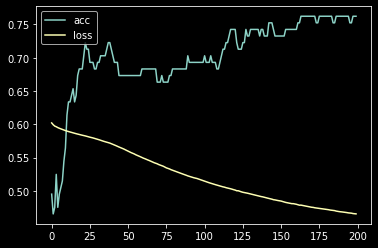

13/13 [==============================] - 0s 19ms/sample - loss: 0.8294 - accuracy: 0.3077


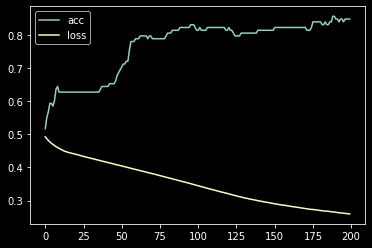

13/13 [==============================] - 0s 18ms/sample - loss: 1.2227 - accuracy: 0.5385


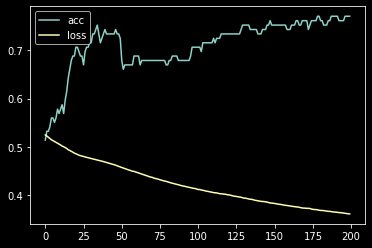

13/13 [==============================] - 0s 18ms/sample - loss: 1.4114 - accuracy: 0.3846


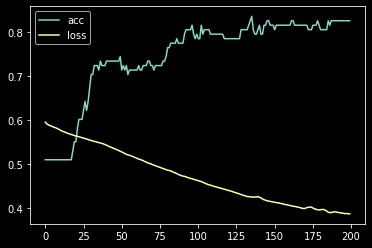

13/13 [==============================] - 0s 19ms/sample - loss: 1.0046 - accuracy: 0.3846


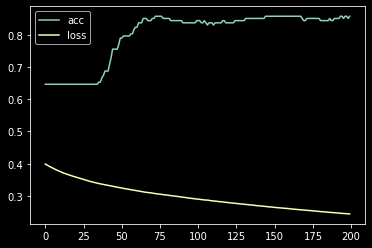

13/13 [==============================] - 0s 21ms/sample - loss: 0.7430 - accuracy: 0.6154


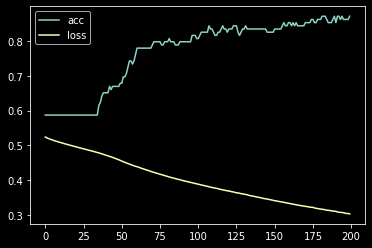

13/13 [==============================] - 0s 18ms/sample - loss: 0.8972 - accuracy: 0.3077


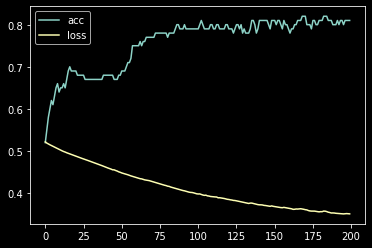

13/13 [==============================] - 0s 18ms/sample - loss: 0.7048 - accuracy: 0.5385


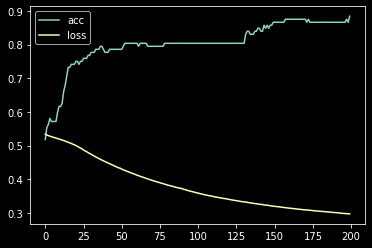

13/13 [==============================] - 0s 22ms/sample - loss: 0.8733 - accuracy: 0.6154


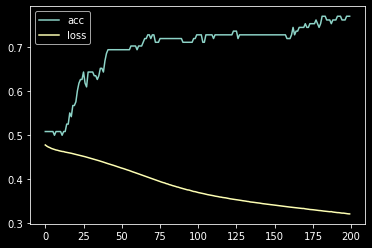

13/13 [==============================] - 0s 18ms/sample - loss: 0.3669 - accuracy: 0.8462


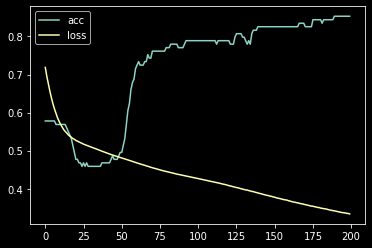

13/13 [==============================] - 0s 19ms/sample - loss: 0.7386 - accuracy: 0.6154


In [72]:
nn_pmodels, nn_presults = runNNEval(20, trainPNN, evaluatePNN)

In [85]:
lr_results

[{'0.0': {'precision': 0.6363636363636364,
   'recall': 1.0,
   'f1-score': 0.7777777777777778,
   'support': 7},
  '1.0': {'precision': 1.0,
   'recall': 0.3333333333333333,
   'f1-score': 0.5,
   'support': 6},
  'accuracy': 0.6923076923076923,
  'macro avg': {'precision': 0.8181818181818181,
   'recall': 0.6666666666666666,
   'f1-score': 0.6388888888888888,
   'support': 13},
  'weighted avg': {'precision': 0.804195804195804,
   'recall': 0.6923076923076923,
   'f1-score': 0.6495726495726496,
   'support': 13},
  'best_params': {'penalty': 'l2',
   'C': 0.021544346900318846,
   'solver': 'liblinear'}},
 {'0.0': {'precision': 0.625,
   'recall': 0.5555555555555556,
   'f1-score': 0.5882352941176471,
   'support': 9},
  '1.0': {'precision': 0.2,
   'recall': 0.25,
   'f1-score': 0.22222222222222224,
   'support': 4},
  'accuracy': 0.46153846153846156,
  'macro avg': {'precision': 0.4125,
   'recall': 0.4027777777777778,
   'f1-score': 0.40522875816993464,
   'support': 13},
  'weight

65/65 [==============================] - 0s 6ms/sample - loss: 0.6377 - accuracy: 0.7077 - auc: 0.7767
[0.6377325113003071, 0.7076923, 0.77666664]


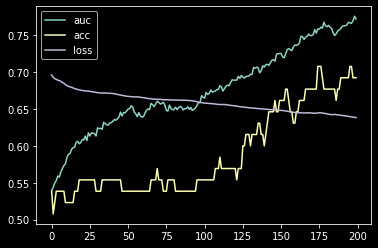

65/65 [==============================] - 0s 6ms/sample - loss: 0.5846 - accuracy: 0.7385 - auc: 0.8457
[0.5845947756217076, 0.73846155, 0.8457142]


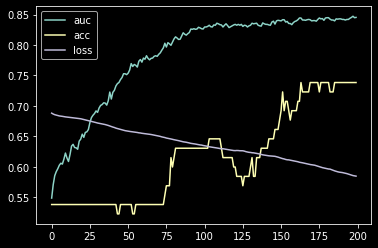

65/65 [==============================] - 0s 6ms/sample - loss: 0.6169 - accuracy: 0.7538 - auc: 0.8090
[0.616897150186392, 0.75384617, 0.8090476]


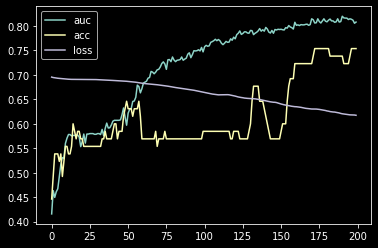

66/66 [==============================] - 0s 6ms/sample - loss: 0.5943 - accuracy: 0.7121 - auc: 0.7862
[0.5943381118051934, 0.7121212, 0.78617513]


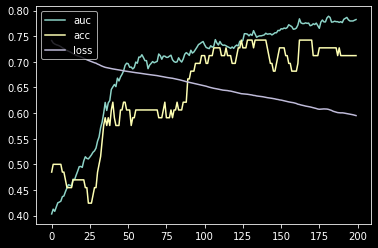

67/67 [==============================] - 0s 6ms/sample - loss: 0.5875 - accuracy: 0.7164 - auc: 0.8145
[0.587471598119878, 0.7164179, 0.81451607]


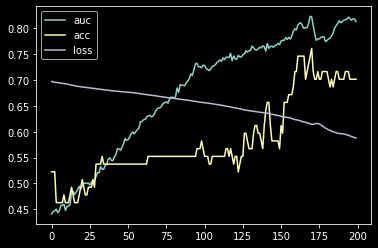

65/65 [==============================] - 0s 6ms/sample - loss: 0.6105 - accuracy: 0.7538 - auc: 0.8190
[0.6105388448788569, 0.75384617, 0.81904763]


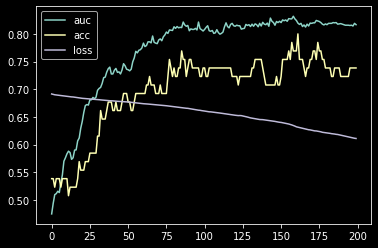

65/65 [==============================] - 1s 14ms/sample - loss: 0.6238 - accuracy: 0.7231 - auc: 0.7519
[0.6238406410584083, 0.72307694, 0.7519048]


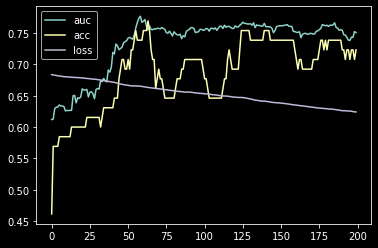

65/65 [==============================] - 0s 6ms/sample - loss: 0.6004 - accuracy: 0.6923 - auc: 0.8186
[0.6004030594458947, 0.6923077, 0.81857145]


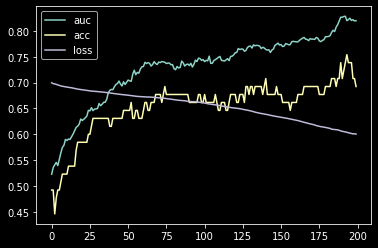

66/66 [==============================] - 0s 6ms/sample - loss: 0.5856 - accuracy: 0.7727 - auc: 0.8922
[0.585617027499459, 0.77272725, 0.8921659]


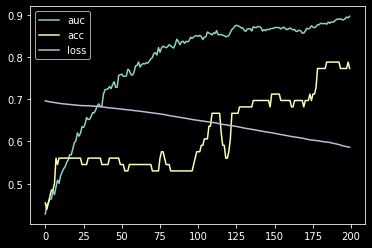

67/67 [==============================] - 0s 6ms/sample - loss: 0.6029 - accuracy: 0.7463 - auc: 0.7849
[0.6028888910564024, 0.74626863, 0.7849462]


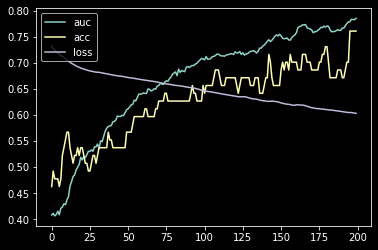

65/65 [==============================] - 0s 6ms/sample - loss: 0.6227 - accuracy: 0.5385 - auc: 0.7124
[0.62268378000993, 0.53846157, 0.71238095]


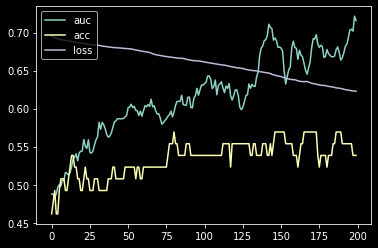

17/17 [==============================] - 0s 0s/sample - loss: 0.6476 - accuracy: 0.5294 - auc: 0.5694


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


65/65 [==============================] - 0s 6ms/sample - loss: 0.6682 - accuracy: 0.5385 - auc: 0.7095
[0.6681765065743372, 0.53846157, 0.7095238]


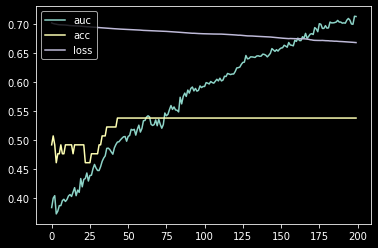

17/17 [==============================] - 0s 0s/sample - loss: 0.7064 - accuracy: 0.5294 - auc: 0.4514


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


65/65 [==============================] - 0s 6ms/sample - loss: 0.5993 - accuracy: 0.7077 - auc: 0.8429
[0.5993290997468508, 0.7076923, 0.8428572]


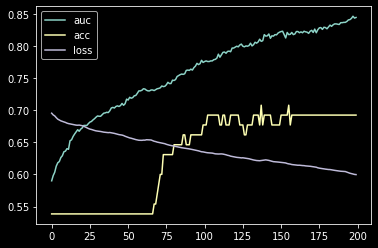

66/66 [==============================] - 0s 6ms/sample - loss: 0.6688 - accuracy: 0.6061 - auc: 0.6820
[0.6687735409447642, 0.6060606, 0.68202764]


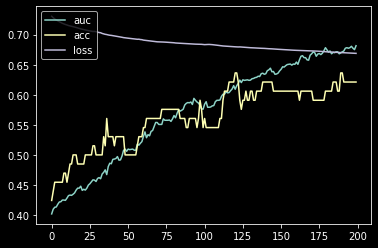

67/67 [==============================] - 0s 6ms/sample - loss: 0.5116 - accuracy: 0.7910 - auc: 0.8477
[0.5115562624006129, 0.7910448, 0.8476702]


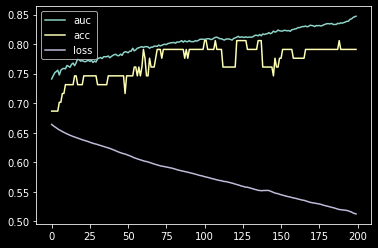

65/65 [==============================] - 0s 6ms/sample - loss: 0.5692 - accuracy: 0.7077 - auc: 0.8219
[0.5691732635864845, 0.7076923, 0.8219048]


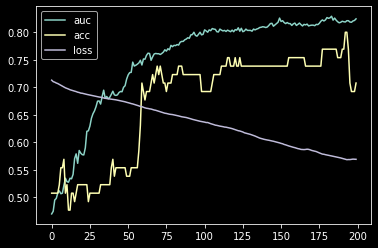

65/65 [==============================] - 0s 6ms/sample - loss: 0.6300 - accuracy: 0.5692 - auc: 0.8529
[0.6300485849380493, 0.5692308, 0.8528571]


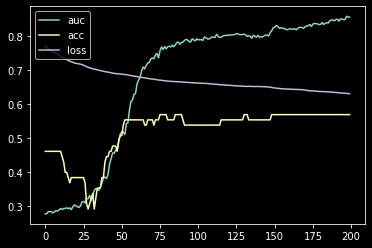

17/17 [==============================] - 0s 0s/sample - loss: 0.7021 - accuracy: 0.5294 - auc: 0.5347


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


65/65 [==============================] - 0s 6ms/sample - loss: 0.6504 - accuracy: 0.5385 - auc: 0.8314
[0.6504112326181852, 0.53846157, 0.8314285]


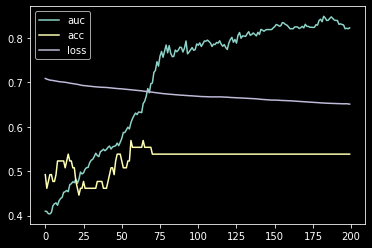

17/17 [==============================] - 0s 918us/sample - loss: 0.6897 - accuracy: 0.5294 - auc: 0.5833


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


66/66 [==============================] - 0s 6ms/sample - loss: 0.5926 - accuracy: 0.7424 - auc: 0.8313
[0.5926369699564847, 0.74242425, 0.83133644]


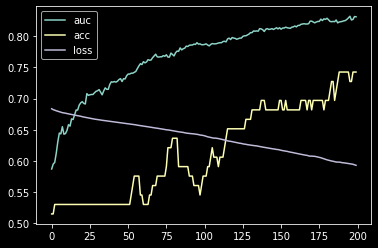

67/67 [==============================] - 0s 6ms/sample - loss: 0.6768 - accuracy: 0.5970 - auc: 0.7025
[0.676803031074467, 0.5970149, 0.7025089]


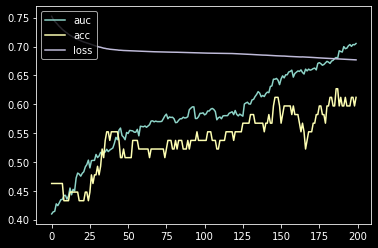

65/65 [==============================] - 0s 6ms/sample - loss: 0.6840 - accuracy: 0.6308 - auc: 0.5824
[0.6840236186981201, 0.63076925, 0.582381]


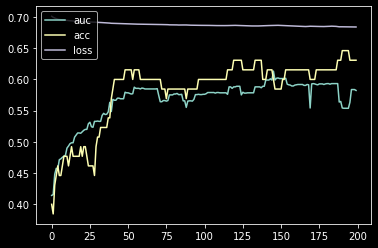

65/65 [==============================] - 0s 6ms/sample - loss: 0.6583 - accuracy: 0.5231 - auc: 0.6805
[0.658323570398184, 0.52307695, 0.6804762]


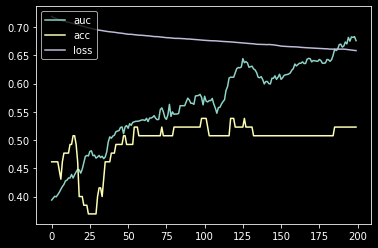

65/65 [==============================] - 0s 6ms/sample - loss: 0.6384 - accuracy: 0.6308 - auc: 0.8486
[0.6384017109870911, 0.63076925, 0.8485714]


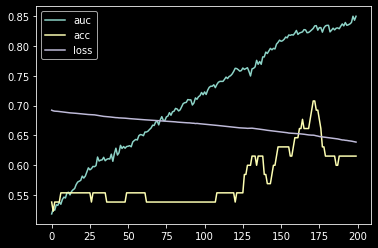

66/66 [==============================] - 0s 6ms/sample - loss: 0.6568 - accuracy: 0.6667 - auc: 0.6355
[0.6567714846495426, 0.6666667, 0.63548386]


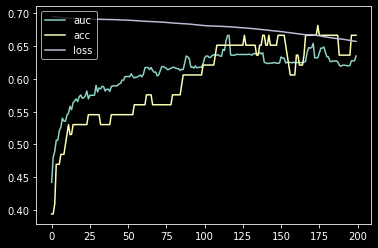

67/67 [==============================] - 0s 6ms/sample - loss: 0.5806 - accuracy: 0.6716 - auc: 0.8463
[0.5806303033188208, 0.67164177, 0.8463262]


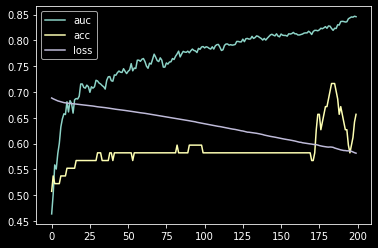

65/65 [==============================] - 0s 6ms/sample - loss: 0.6112 - accuracy: 0.6615 - auc: 0.7676
[0.6112435469260582, 0.6615385, 0.7676191]


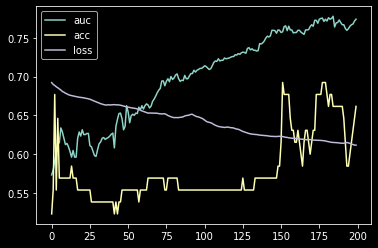

65/65 [==============================] - 0s 6ms/sample - loss: 0.6313 - accuracy: 0.6615 - auc: 0.7248
[0.6312544006567735, 0.6615385, 0.72476184]


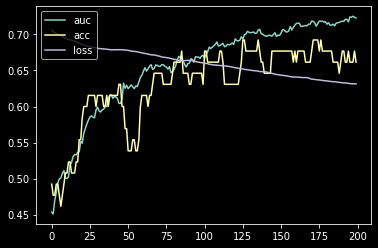

65/65 [==============================] - 0s 6ms/sample - loss: 0.5976 - accuracy: 0.6923 - auc: 0.8329
[0.597623211145401, 0.6923077, 0.83285713]


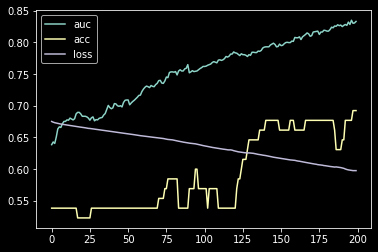

66/66 [==============================] - 0s 6ms/sample - loss: 0.5438 - accuracy: 0.7424 - auc: 0.8304
[0.5437528509082217, 0.74242425, 0.8304148]


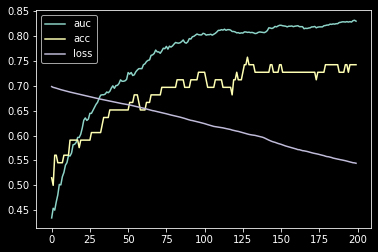

67/67 [==============================] - 0s 6ms/sample - loss: 0.5414 - accuracy: 0.7761 - auc: 0.8978
[0.5413861977520273, 0.7761194, 0.89784944]


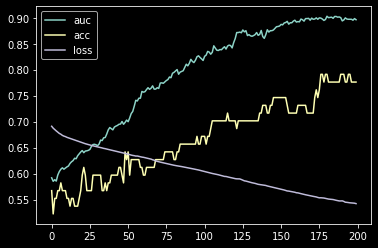

65/65 [==============================] - 0s 6ms/sample - loss: 0.6307 - accuracy: 0.6462 - auc: 0.7533
[0.6307110859797551, 0.64615387, 0.75333333]


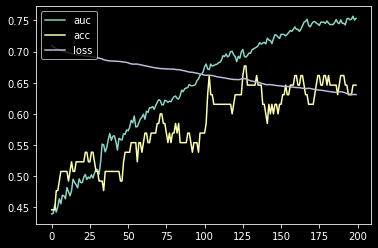

65/65 [==============================] - 0s 6ms/sample - loss: 0.5433 - accuracy: 0.8154 - auc: 0.8881
[0.5432721110490653, 0.8153846, 0.8880952]


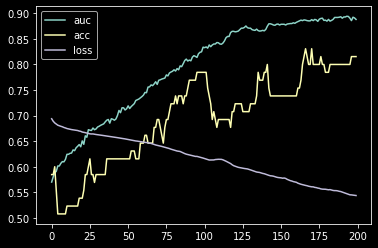

65/65 [==============================] - 2s 32ms/sample - loss: 0.6431 - accuracy: 0.6308 - auc: 0.7552
[0.6430843266157004, 0.63076925, 0.75523806]


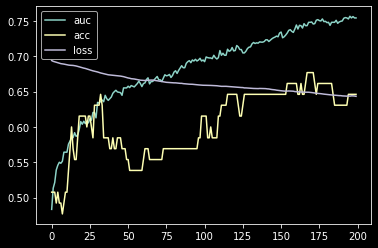

66/66 [==============================] - 0s 6ms/sample - loss: 0.5842 - accuracy: 0.6515 - auc: 0.8106
[0.5842027266820272, 0.6515151, 0.8105991]


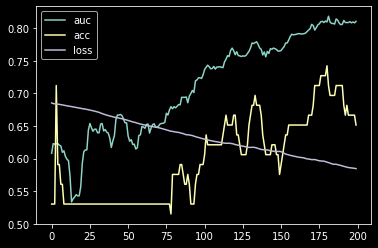

67/67 [==============================] - 0s 5ms/sample - loss: 0.6091 - accuracy: 0.7164 - auc: 0.8311
[0.6090886637346068, 0.7164179, 0.8310932]


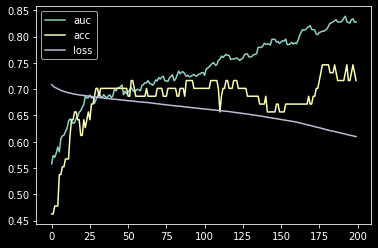

65/65 [==============================] - 0s 6ms/sample - loss: 0.5861 - accuracy: 0.7385 - auc: 0.8033
[0.5861263687794025, 0.73846155, 0.8033334]


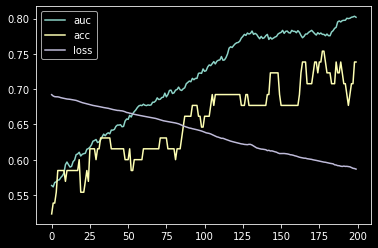

65/65 [==============================] - 0s 6ms/sample - loss: 0.5891 - accuracy: 0.7385 - auc: 0.8524
[0.5890775295404288, 0.73846155, 0.8523809]


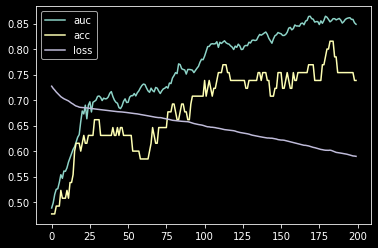

65/65 [==============================] - 0s 6ms/sample - loss: 0.6446 - accuracy: 0.6000 - auc: 0.6986
[0.6445657565043523, 0.6, 0.6985714]


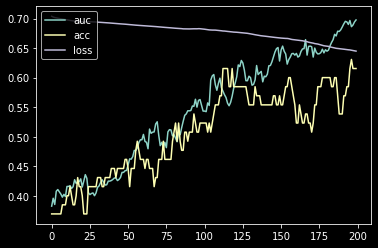

17/17 [==============================] - 0s 0s/sample - loss: 0.6226 - accuracy: 0.5294 - auc: 0.7778


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


66/66 [==============================] - 0s 6ms/sample - loss: 0.6107 - accuracy: 0.6818 - auc: 0.8097
[0.6106986421527285, 0.6818182, 0.8096774]


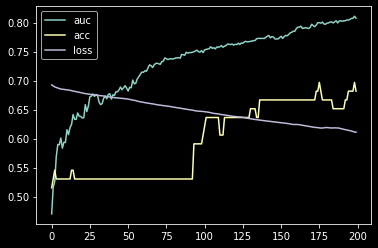

67/67 [==============================] - 0s 6ms/sample - loss: 0.5978 - accuracy: 0.7313 - auc: 0.7827
[0.5977942285253041, 0.73134327, 0.7827061]


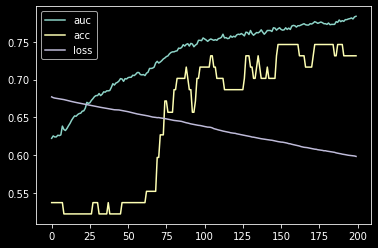

65/65 [==============================] - 0s 6ms/sample - loss: 0.6393 - accuracy: 0.6615 - auc: 0.7843
[0.6392995357513428, 0.6615385, 0.7842857]


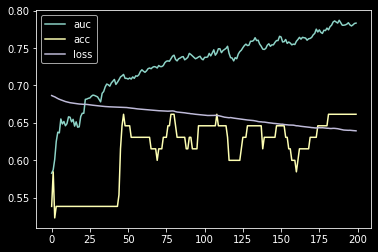

65/65 [==============================] - 0s 6ms/sample - loss: 0.5447 - accuracy: 0.7692 - auc: 0.8462
[0.544719319160168, 0.7692308, 0.84619045]


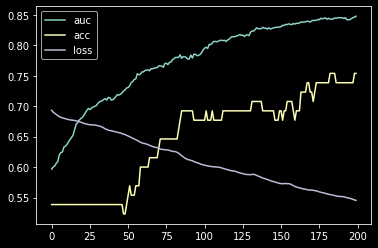

65/65 [==============================] - 0s 6ms/sample - loss: 0.6546 - accuracy: 0.6615 - auc: 0.7771
[0.6545935823367193, 0.6615385, 0.7771429]


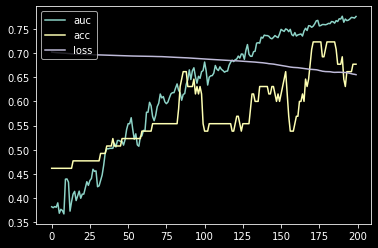

66/66 [==============================] - 0s 6ms/sample - loss: 0.5609 - accuracy: 0.7576 - auc: 0.7825
[0.5608772906390104, 0.75757575, 0.78248847]


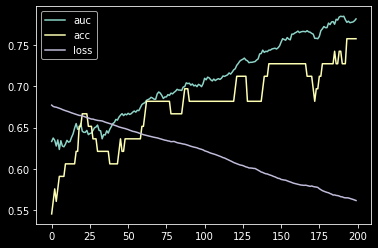

67/67 [==============================] - 0s 6ms/sample - loss: 0.5463 - accuracy: 0.7761 - auc: 0.8468
[0.5463191430960128, 0.7761194, 0.84677416]


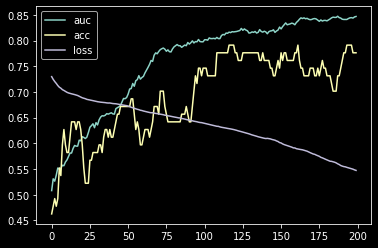

65/65 [==============================] - 0s 6ms/sample - loss: 0.6395 - accuracy: 0.5385 - auc: 0.7005
[0.6395226056759175, 0.53846157, 0.70047617]


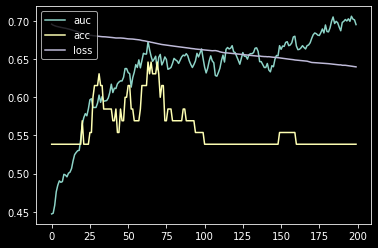

17/17 [==============================] - 0s 0s/sample - loss: 0.6626 - accuracy: 0.5294 - auc: 0.6597


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


65/65 [==============================] - 0s 6ms/sample - loss: 0.6294 - accuracy: 0.6923 - auc: 0.8324
[0.629365991629087, 0.6923077, 0.83238095]


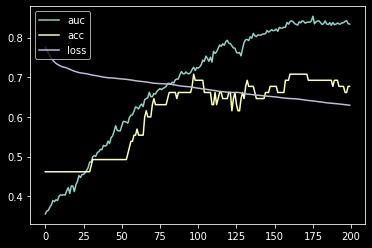

65/65 [==============================] - 0s 6ms/sample - loss: 0.6378 - accuracy: 0.6769 - auc: 0.7310
[0.6377921241980332, 0.6769231, 0.7309524]


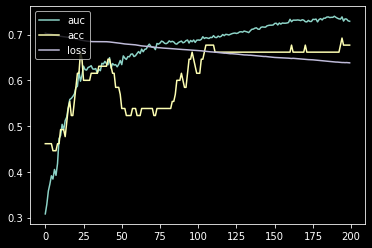

66/66 [==============================] - 0s 6ms/sample - loss: 0.5910 - accuracy: 0.6970 - auc: 0.8249
[0.5910109733090256, 0.6969697, 0.8248848]


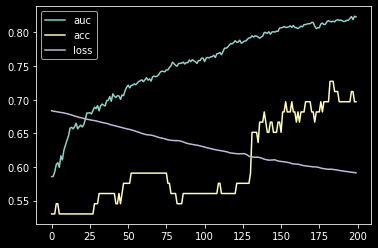

67/67 [==============================] - 0s 6ms/sample - loss: 0.5510 - accuracy: 0.6866 - auc: 0.8383
[0.5509847571600729, 0.6865672, 0.83826166]


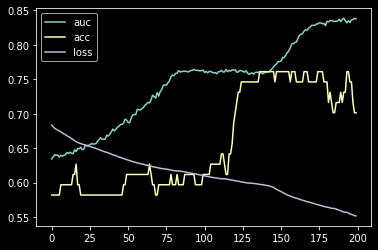

65/65 [==============================] - 0s 6ms/sample - loss: 0.6350 - accuracy: 0.6615 - auc: 0.7776
[0.6350106248488793, 0.6615385, 0.77761906]


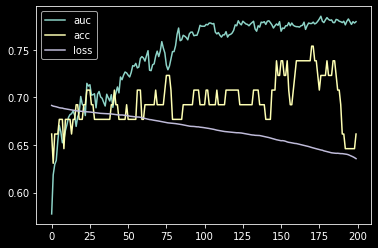

65/65 [==============================] - 0s 6ms/sample - loss: 0.6752 - accuracy: 0.5692 - auc: 0.6148
[0.6752356905203599, 0.5692308, 0.61476195]


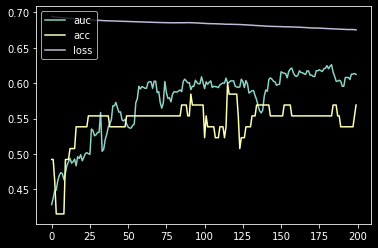

17/17 [==============================] - 0s 0s/sample - loss: 0.6795 - accuracy: 0.5294 - auc: 0.5833


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


65/65 [==============================] - 0s 6ms/sample - loss: 0.6304 - accuracy: 0.7077 - auc: 0.8090
[0.630446862257444, 0.7076923, 0.80904764]


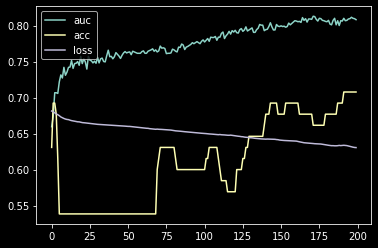

66/66 [==============================] - 0s 6ms/sample - loss: 0.6424 - accuracy: 0.7121 - auc: 0.7613
[0.6423701047897339, 0.7121212, 0.7612903]


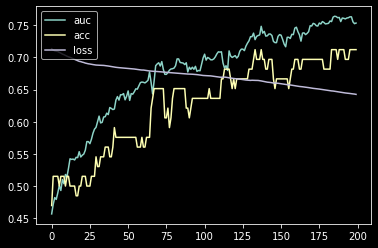

67/67 [==============================] - 0s 6ms/sample - loss: 0.6099 - accuracy: 0.7015 - auc: 0.7733
[0.6099495451841781, 0.70149255, 0.7732974]


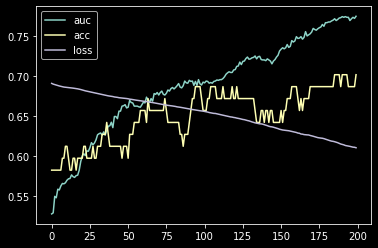

65/65 [==============================] - 2s 36ms/sample - loss: 0.6537 - accuracy: 0.5385 - auc: 0.7648
[0.6536521370594318, 0.53846157, 0.7647619]


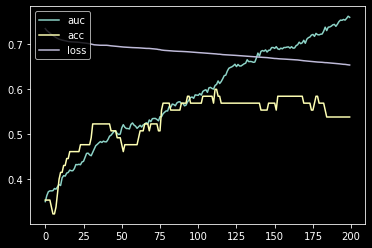

17/17 [==============================] - 0s 0s/sample - loss: 0.6884 - accuracy: 0.5294 - auc: 0.6181


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


65/65 [==============================] - 0s 6ms/sample - loss: 0.5969 - accuracy: 0.6769 - auc: 0.7486
[0.5969224737240718, 0.6769231, 0.7485714]


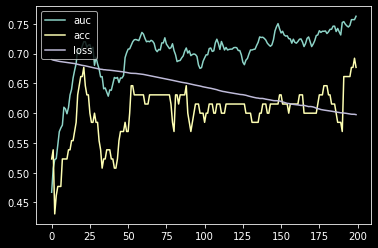

65/65 [==============================] - 0s 7ms/sample - loss: 0.5623 - accuracy: 0.8000 - auc: 0.8790
[0.5622780460577744, 0.8, 0.8790476]


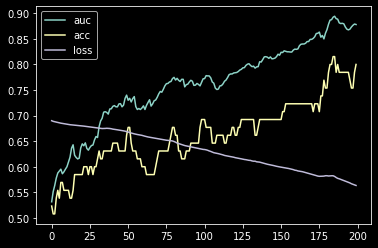

66/66 [==============================] - 0s 6ms/sample - loss: 0.6569 - accuracy: 0.6061 - auc: 0.7046
[0.6568507588270939, 0.6060606, 0.7046083]


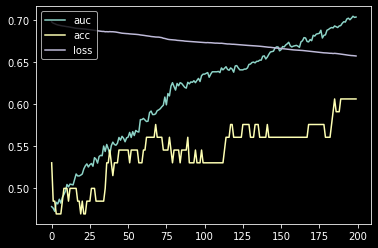

67/67 [==============================] - 0s 6ms/sample - loss: 0.6248 - accuracy: 0.6716 - auc: 0.7814
[0.6248439247928449, 0.67164177, 0.78136194]


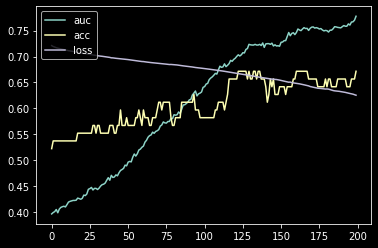

65/65 [==============================] - 0s 6ms/sample - loss: 0.6420 - accuracy: 0.5385 - auc: 0.7505
[0.6420388139211215, 0.53846157, 0.75047624]


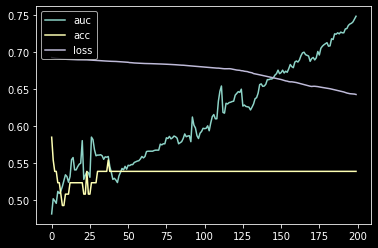

17/17 [==============================] - 0s 0s/sample - loss: 0.6898 - accuracy: 0.5294 - auc: 0.5833


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


65/65 [==============================] - 0s 6ms/sample - loss: 0.5872 - accuracy: 0.7231 - auc: 0.7957
[0.5872129532007071, 0.72307694, 0.79571426]


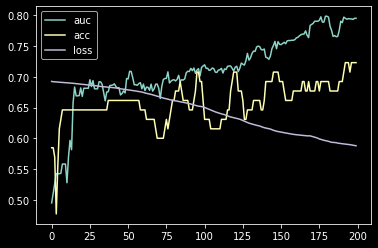

65/65 [==============================] - 0s 6ms/sample - loss: 0.5811 - accuracy: 0.7077 - auc: 0.7881
[0.5811238252199613, 0.7076923, 0.78809524]


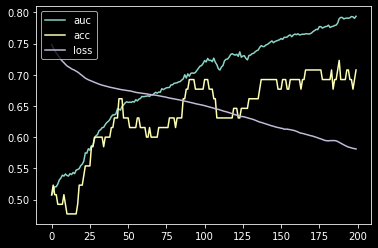

66/66 [==============================] - 0s 6ms/sample - loss: 0.5612 - accuracy: 0.7576 - auc: 0.8387
[0.5611706935998165, 0.75757575, 0.8387096]


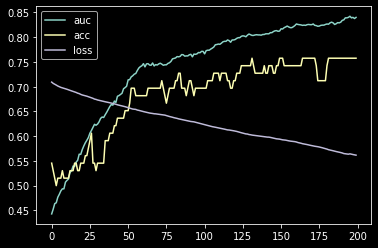

67/67 [==============================] - 0s 6ms/sample - loss: 0.6029 - accuracy: 0.6716 - auc: 0.7527
[0.6028587818145752, 0.67164177, 0.75268817]


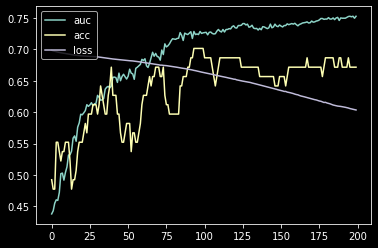

65/65 [==============================] - 0s 6ms/sample - loss: 0.6225 - accuracy: 0.6462 - auc: 0.8014
[0.6225288281073937, 0.64615387, 0.80142856]


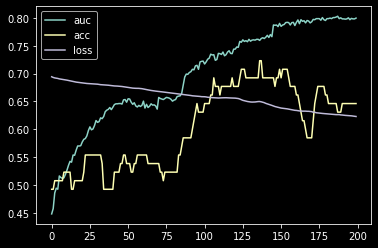

65/65 [==============================] - 0s 6ms/sample - loss: 0.5911 - accuracy: 0.7385 - auc: 0.8167
[0.5910915604004493, 0.73846155, 0.8166667]


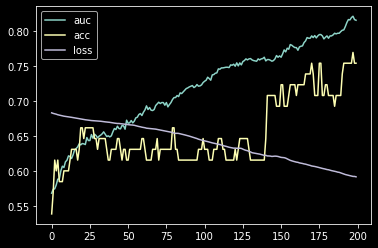

65/65 [==============================] - 0s 6ms/sample - loss: 0.6119 - accuracy: 0.7385 - auc: 0.8019
[0.6119337687125572, 0.73846155, 0.80190474]


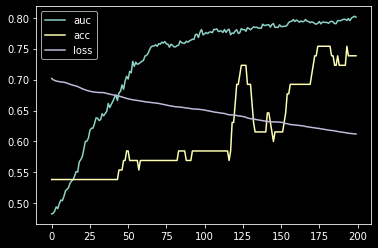

66/66 [==============================] - 0s 6ms/sample - loss: 0.6569 - accuracy: 0.6364 - auc: 0.7240
[0.6568526499199144, 0.6363636, 0.72396314]


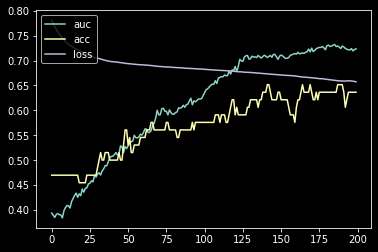

67/67 [==============================] - 0s 6ms/sample - loss: 0.5957 - accuracy: 0.7015 - auc: 0.8100
[0.5957390505876115, 0.70149255, 0.8100358]


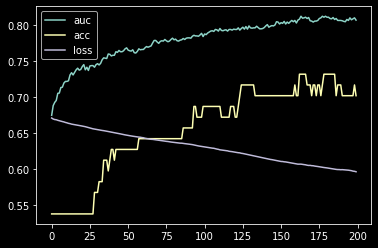

65/65 [==============================] - 3s 45ms/sample - loss: 0.5891 - accuracy: 0.7692 - auc: 0.7857
[0.5891418383671687, 0.7692308, 0.78571427]


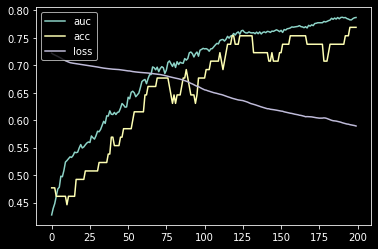

65/65 [==============================] - 0s 6ms/sample - loss: 0.6457 - accuracy: 0.7231 - auc: 0.7852
[0.645657795209151, 0.72307694, 0.785238]


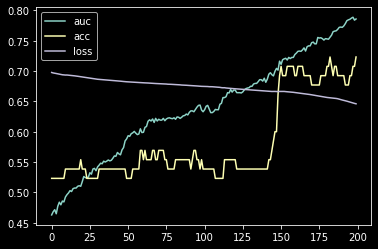

65/65 [==============================] - 0s 6ms/sample - loss: 0.6061 - accuracy: 0.6769 - auc: 0.7490
[0.6060793849138113, 0.6769231, 0.74904764]


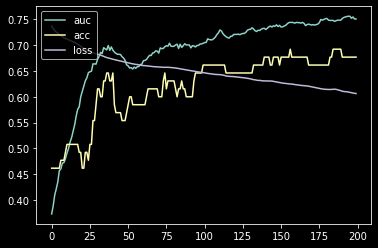

66/66 [==============================] - 0s 6ms/sample - loss: 0.6043 - accuracy: 0.6970 - auc: 0.7737
[0.6043049945975795, 0.6969697, 0.7737327]


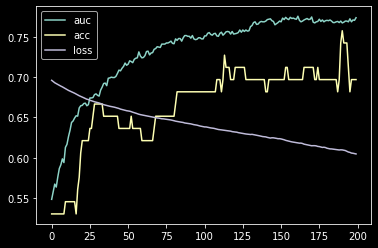

67/67 [==============================] - 0s 5ms/sample - loss: 0.5538 - accuracy: 0.7313 - auc: 0.8073
[0.5537608995366452, 0.73134327, 0.80734766]


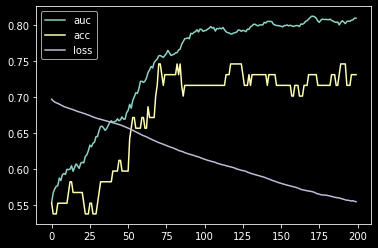

65/65 [==============================] - 0s 6ms/sample - loss: 0.6352 - accuracy: 0.7538 - auc: 0.8167
[0.6352391939896803, 0.75384617, 0.81666666]


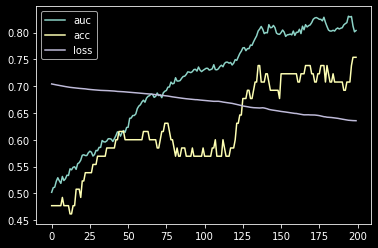

65/65 [==============================] - 0s 7ms/sample - loss: 0.6323 - accuracy: 0.6923 - auc: 0.7529
[0.6322908658247728, 0.6923077, 0.75285715]


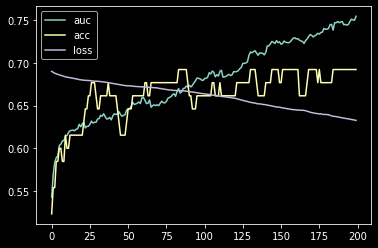

65/65 [==============================] - 0s 6ms/sample - loss: 0.6871 - accuracy: 0.5692 - auc: 0.5229
[0.6870873918900123, 0.5692308, 0.5228571]


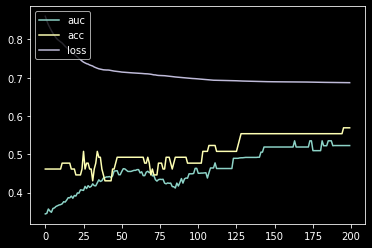

66/66 [==============================] - 0s 6ms/sample - loss: 0.6329 - accuracy: 0.6818 - auc: 0.7567
[0.6329388365601049, 0.6818182, 0.75668204]


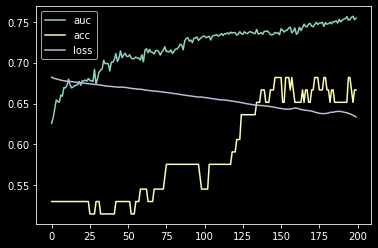

67/67 [==============================] - 0s 6ms/sample - loss: 0.5630 - accuracy: 0.7463 - auc: 0.8100
[0.5630490673122122, 0.74626863, 0.8100358]


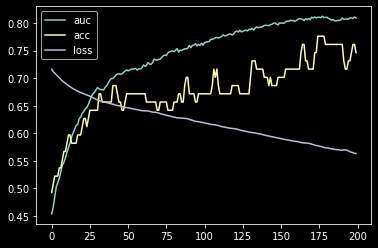

65/65 [==============================] - 0s 6ms/sample - loss: 0.6385 - accuracy: 0.6000 - auc: 0.8143
[0.6385251366175138, 0.6, 0.81428576]


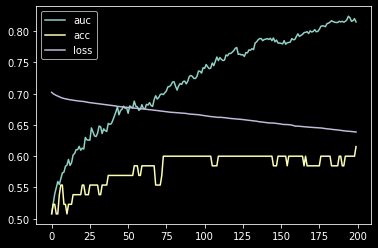

65/65 [==============================] - 0s 6ms/sample - loss: 0.5678 - accuracy: 0.7077 - auc: 0.7681
[0.5678283663896414, 0.7076923, 0.76809525]


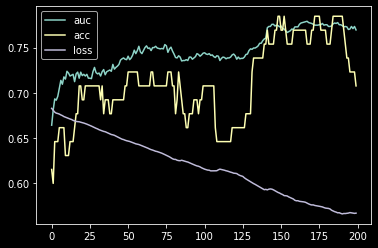

65/65 [==============================] - 0s 6ms/sample - loss: 0.6609 - accuracy: 0.7077 - auc: 0.7376
[0.6609155893325805, 0.7076923, 0.73761904]


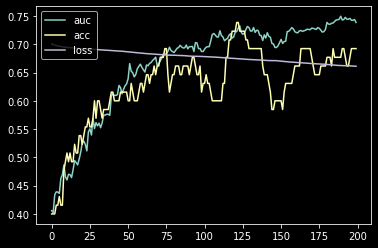

66/66 [==============================] - 0s 6ms/sample - loss: 0.5726 - accuracy: 0.7121 - auc: 0.8180
[0.5726411288434808, 0.7121212, 0.81797236]


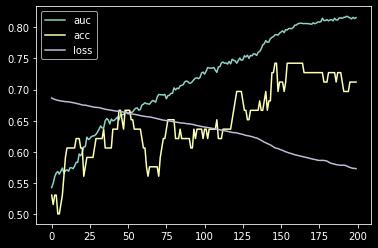

67/67 [==============================] - 0s 7ms/sample - loss: 0.5431 - accuracy: 0.7761 - auc: 0.8056
[0.5431417128933009, 0.7761194, 0.80555546]


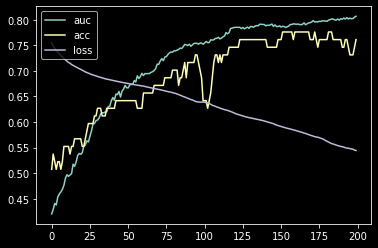

65/65 [==============================] - 0s 6ms/sample - loss: 0.6265 - accuracy: 0.6769 - auc: 0.7914
[0.6265102276435265, 0.6769231, 0.79142857]


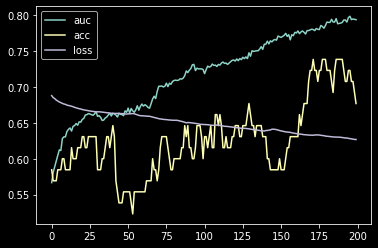

65/65 [==============================] - 0s 6ms/sample - loss: 0.5809 - accuracy: 0.7385 - auc: 0.8448
[0.5809096749012287, 0.73846155, 0.84476197]


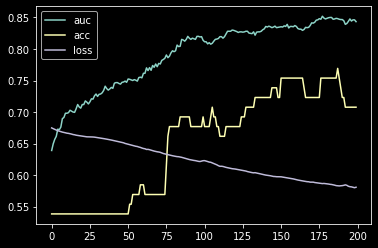

17/17 [==============================] - 0s 0s/sample - loss: 0.7693 - accuracy: 0.5294 - auc: 0.4028


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


65/65 [==============================] - 0s 6ms/sample - loss: 0.5991 - accuracy: 0.7077 - auc: 0.7752
[0.5990559674226321, 0.7076923, 0.7752381]


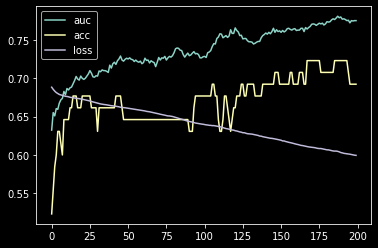

66/66 [==============================] - 0s 6ms/sample - loss: 0.4994 - accuracy: 0.8182 - auc: 0.8770
[0.4994185612057195, 0.8181818, 0.8769585]


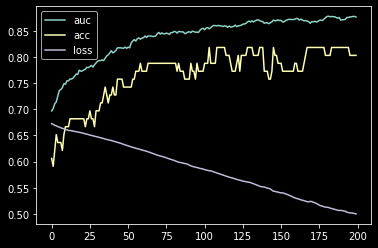

67/67 [==============================] - 0s 5ms/sample - loss: 0.5638 - accuracy: 0.7164 - auc: 0.8365
[0.5638228032126356, 0.7164179, 0.83646953]


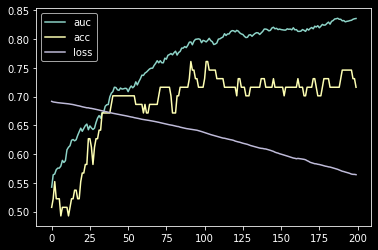

65/65 [==============================] - 0s 6ms/sample - loss: 0.6649 - accuracy: 0.6462 - auc: 0.6686
[0.664874439056103, 0.64615387, 0.6685715]


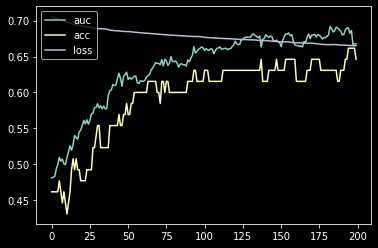

65/65 [==============================] - 0s 6ms/sample - loss: 0.5864 - accuracy: 0.6769 - auc: 0.8695
[0.5863893114603482, 0.6769231, 0.8695238]


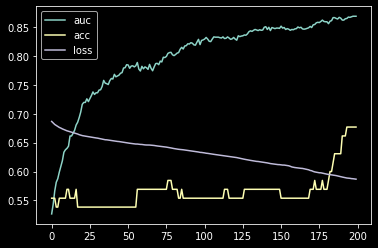

65/65 [==============================] - 0s 6ms/sample - loss: 0.6904 - accuracy: 0.5385 - auc: 0.5586
[0.6904136905303369, 0.53846157, 0.55857146]


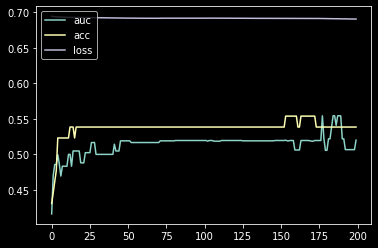

17/17 [==============================] - 0s 0s/sample - loss: 0.6903 - accuracy: 0.5294 - auc: 0.6042


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


66/66 [==============================] - 0s 6ms/sample - loss: 0.5819 - accuracy: 0.8333 - auc: 0.8346
[0.5819148078109279, 0.8333333, 0.8345622]


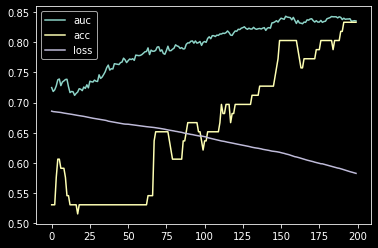

67/67 [==============================] - 0s 6ms/sample - loss: 0.6692 - accuracy: 0.6866 - auc: 0.7518
[0.669165027675344, 0.6865672, 0.75179213]


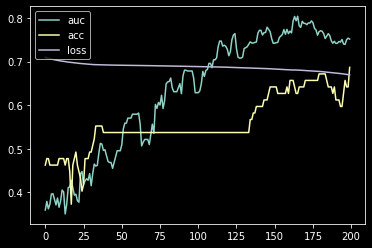

65/65 [==============================] - 0s 6ms/sample - loss: 0.6330 - accuracy: 0.6769 - auc: 0.7452
[0.6330395689377418, 0.6769231, 0.74523807]


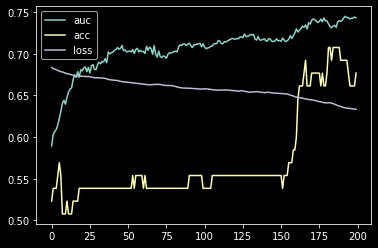

65/65 [==============================] - 0s 6ms/sample - loss: 0.6218 - accuracy: 0.7538 - auc: 0.7933
[0.6218155301534213, 0.75384617, 0.79333335]


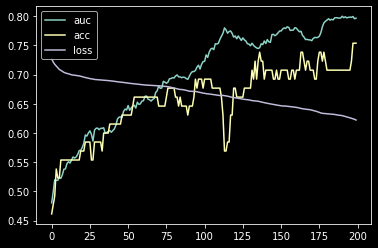

65/65 [==============================] - 0s 6ms/sample - loss: 0.5651 - accuracy: 0.7077 - auc: 0.8462
[0.5650771856307983, 0.7076923, 0.8461905]


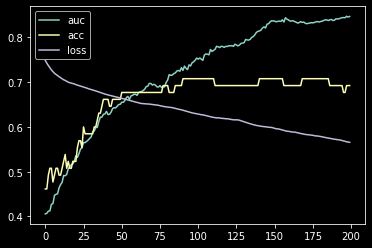

66/66 [==============================] - 0s 6ms/sample - loss: 0.6301 - accuracy: 0.7424 - auc: 0.7714
[0.630058391527696, 0.74242425, 0.7714286]


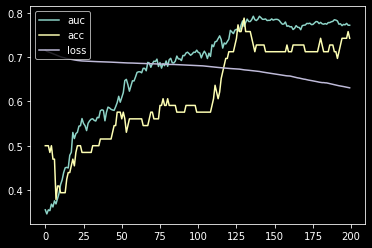

67/67 [==============================] - 0s 5ms/sample - loss: 0.5909 - accuracy: 0.7761 - auc: 0.8190
[0.5909386045897185, 0.7761194, 0.8189964]


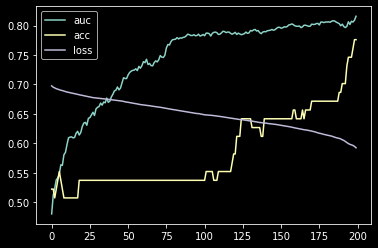

15/15 [==============================] - 0s 0s/sample - loss: 0.7177 - accuracy: 0.6000 - auc: 0.5625


In [140]:
nn_models, nn_results = runClassifierEvalCV(20, trainNN, evaluateNN)

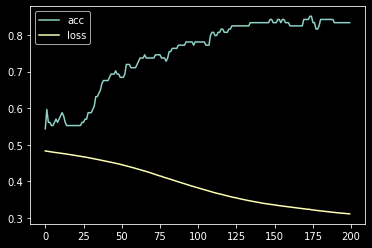

17/17 [==============================] - 0s 8ms/sample - loss: 1.4493 - accuracy: 0.1176


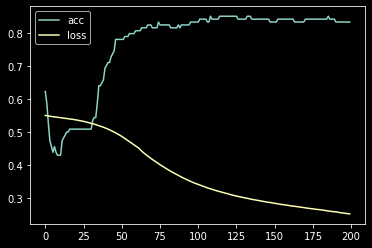

17/17 [==============================] - 0s 8ms/sample - loss: 0.9991 - accuracy: 0.5294


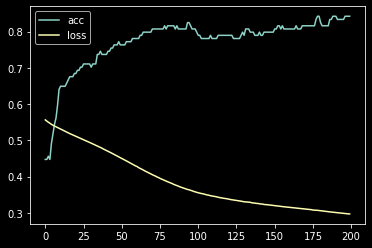

17/17 [==============================] - 0s 8ms/sample - loss: 0.9501 - accuracy: 0.4706


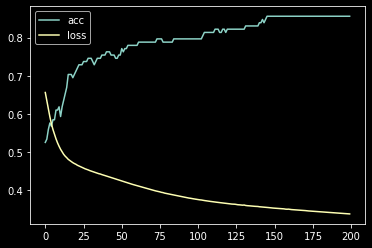

16/16 [==============================] - 0s 8ms/sample - loss: 0.5361 - accuracy: 0.7500


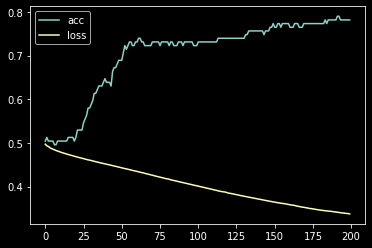

15/15 [==============================] - 0s 10ms/sample - loss: 0.4818 - accuracy: 0.8667


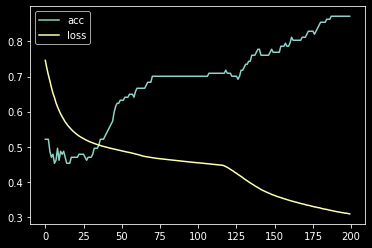

17/17 [==============================] - 0s 7ms/sample - loss: 1.0721 - accuracy: 0.4118


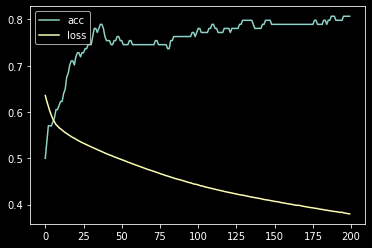

17/17 [==============================] - 0s 8ms/sample - loss: 0.5371 - accuracy: 0.8235


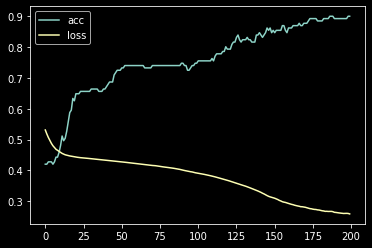

17/17 [==============================] - 0s 8ms/sample - loss: 0.6900 - accuracy: 0.5882


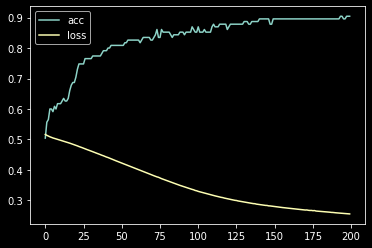

16/16 [==============================] - 0s 8ms/sample - loss: 0.7748 - accuracy: 0.5625


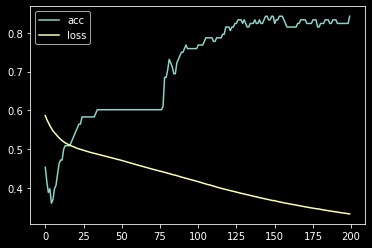

15/15 [==============================] - 0s 9ms/sample - loss: 0.5434 - accuracy: 0.6667


P:\ORD_Singh_201911038D\Maxxxx\B00\cluster_umap.py:134: RuntimeWarning: invalid value encountered in true_divide
  label_clusters = (label_clusters.T / totals).T


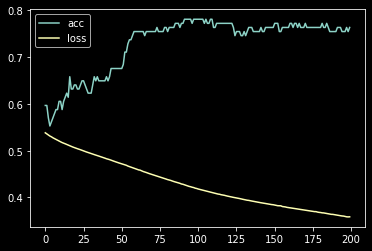

17/17 [==============================] - 0s 7ms/sample - loss: 0.7466 - accuracy: 0.7059


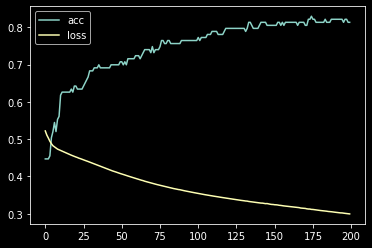

17/17 [==============================] - 0s 9ms/sample - loss: 0.9729 - accuracy: 0.3529


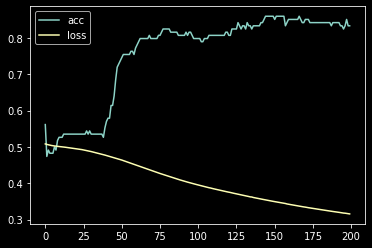

17/17 [==============================] - 0s 8ms/sample - loss: 0.7909 - accuracy: 0.5294


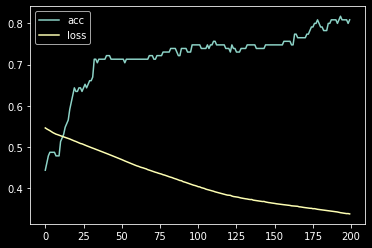

16/16 [==============================] - 0s 9ms/sample - loss: 0.4604 - accuracy: 0.8750


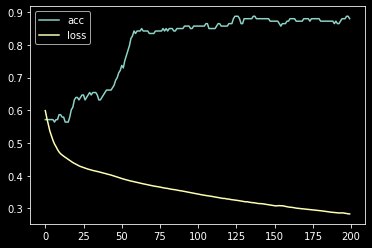

15/15 [==============================] - 0s 9ms/sample - loss: 0.6390 - accuracy: 0.6000


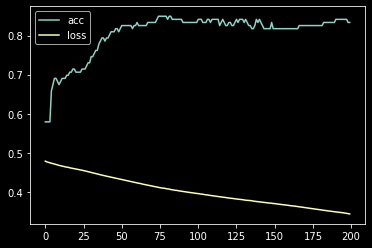

17/17 [==============================] - 0s 8ms/sample - loss: 0.5961 - accuracy: 0.5882


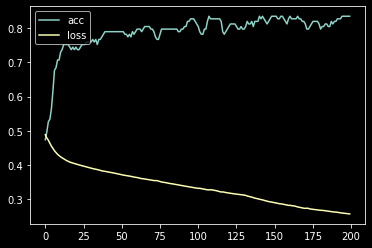

17/17 [==============================] - 0s 9ms/sample - loss: 0.9001 - accuracy: 0.5882


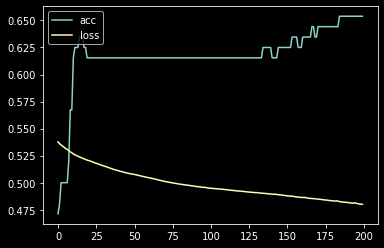

17/17 [==============================] - 0s 8ms/sample - loss: 0.7354 - accuracy: 0.5294


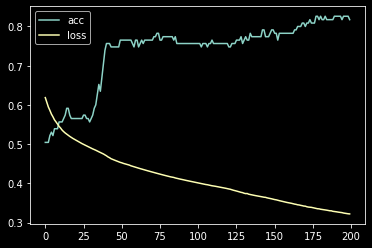

16/16 [==============================] - 0s 9ms/sample - loss: 0.8660 - accuracy: 0.3125


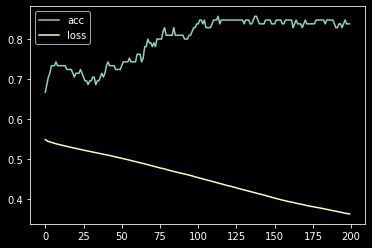

15/15 [==============================] - 0s 9ms/sample - loss: 0.5490 - accuracy: 0.8000


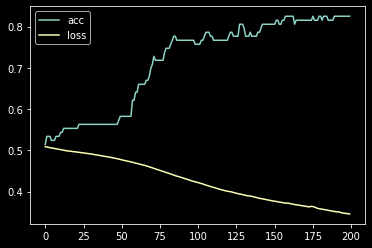

17/17 [==============================] - 0s 8ms/sample - loss: 0.6021 - accuracy: 0.7059


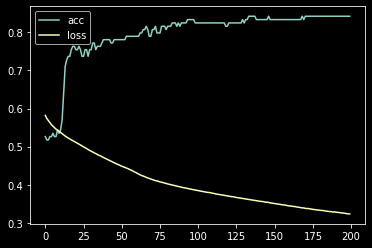

17/17 [==============================] - 0s 8ms/sample - loss: 0.7803 - accuracy: 0.5882


P:\ORD_Singh_201911038D\Maxxxx\B00\cluster_umap.py:134: RuntimeWarning: invalid value encountered in true_divide
  label_clusters = (label_clusters.T / totals).T


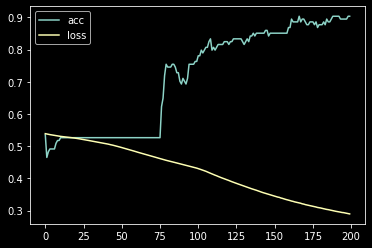

17/17 [==============================] - 0s 8ms/sample - loss: 0.6167 - accuracy: 0.8235


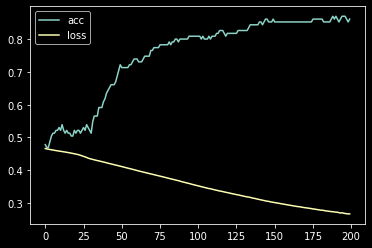

16/16 [==============================] - 0s 8ms/sample - loss: 0.5509 - accuracy: 0.8125


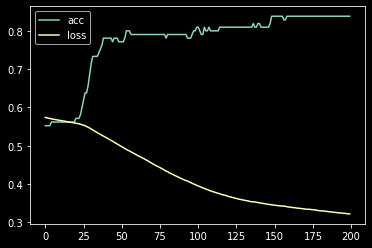

15/15 [==============================] - 0s 9ms/sample - loss: 1.1800 - accuracy: 0.4667


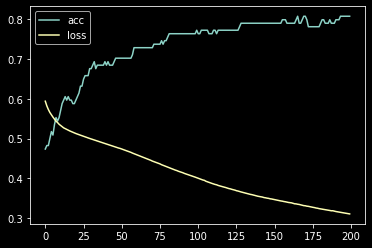

17/17 [==============================] - 0s 8ms/sample - loss: 1.2811 - accuracy: 0.2941


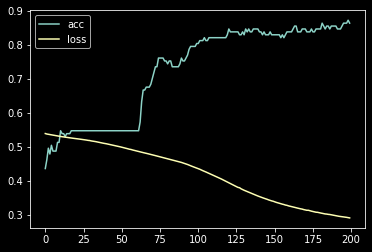

17/17 [==============================] - 0s 8ms/sample - loss: 0.6971 - accuracy: 0.7059


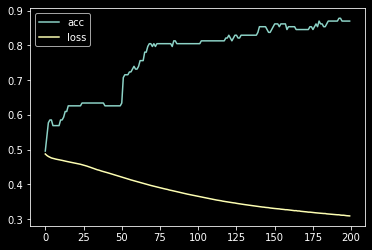

17/17 [==============================] - 0s 8ms/sample - loss: 0.7901 - accuracy: 0.5882


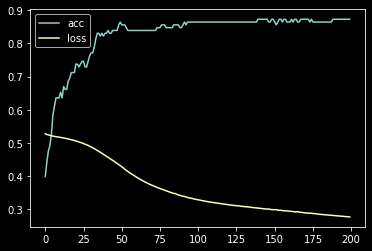

16/16 [==============================] - 0s 8ms/sample - loss: 0.6979 - accuracy: 0.5625


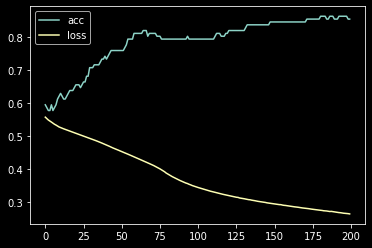

15/15 [==============================] - 0s 9ms/sample - loss: 0.9523 - accuracy: 0.4000


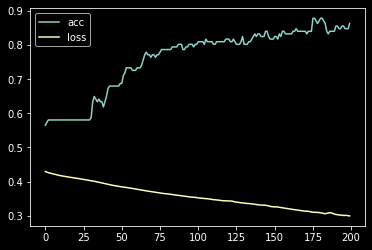

17/17 [==============================] - 0s 8ms/sample - loss: 0.6330 - accuracy: 0.5882


P:\ORD_Singh_201911038D\Maxxxx\B00\cluster_umap.py:134: RuntimeWarning: invalid value encountered in true_divide
  label_clusters = (label_clusters.T / totals).T


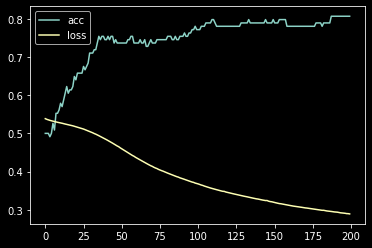

17/17 [==============================] - 0s 8ms/sample - loss: 0.8590 - accuracy: 0.4706


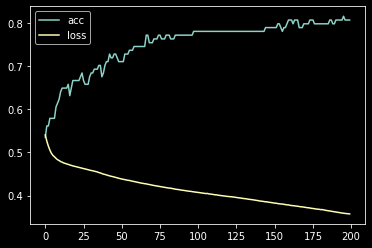

17/17 [==============================] - 0s 8ms/sample - loss: 0.5285 - accuracy: 0.7647


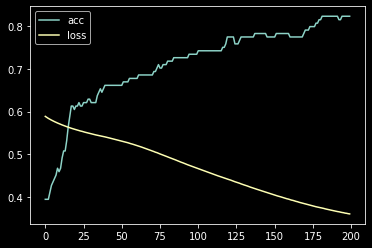

16/16 [==============================] - 0s 8ms/sample - loss: 0.9308 - accuracy: 0.4375


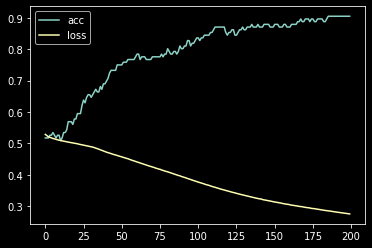

15/15 [==============================] - 0s 9ms/sample - loss: 0.8710 - accuracy: 0.4000


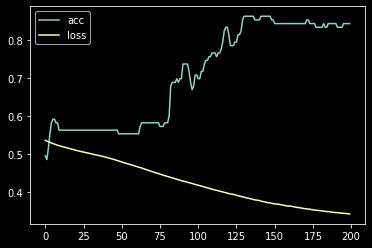

17/17 [==============================] - 0s 8ms/sample - loss: 0.9467 - accuracy: 0.6471


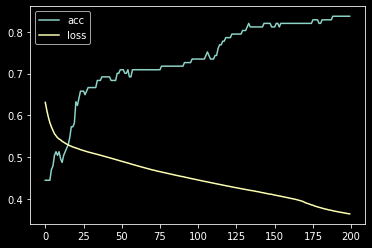

17/17 [==============================] - 0s 8ms/sample - loss: 0.7965 - accuracy: 0.5294


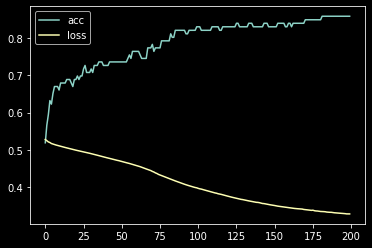

17/17 [==============================] - 0s 8ms/sample - loss: 0.6333 - accuracy: 0.5882


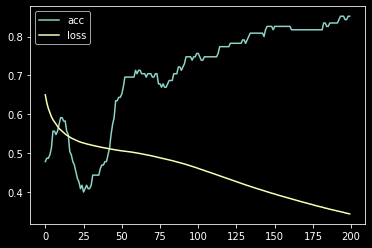

16/16 [==============================] - 0s 8ms/sample - loss: 0.5663 - accuracy: 0.6250


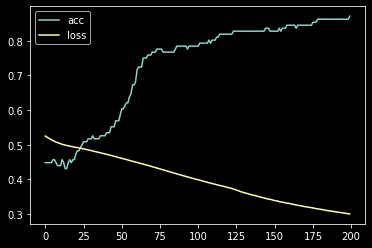

15/15 [==============================] - 0s 9ms/sample - loss: 0.9441 - accuracy: 0.6667


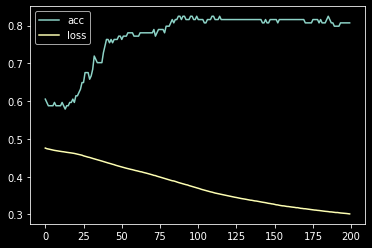

17/17 [==============================] - 0s 8ms/sample - loss: 0.4096 - accuracy: 0.8824


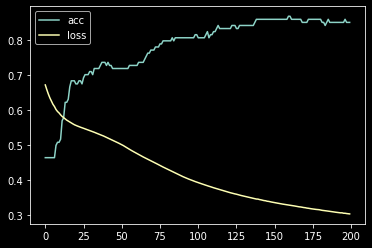

17/17 [==============================] - 0s 8ms/sample - loss: 0.8228 - accuracy: 0.4706


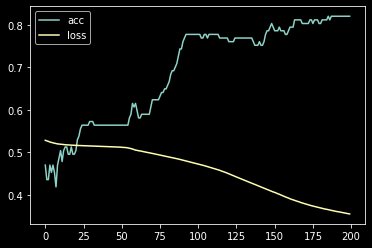

17/17 [==============================] - 0s 8ms/sample - loss: 0.5910 - accuracy: 0.6471


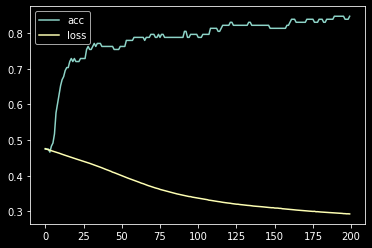

16/16 [==============================] - 0s 9ms/sample - loss: 0.5034 - accuracy: 0.7500


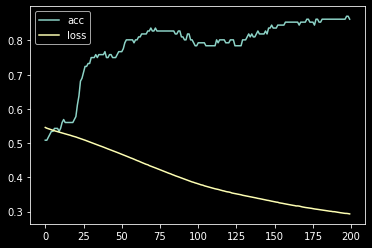

15/15 [==============================] - 0s 9ms/sample - loss: 1.1048 - accuracy: 0.3333


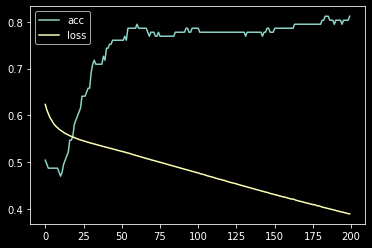

17/17 [==============================] - 0s 8ms/sample - loss: 0.6409 - accuracy: 0.5882


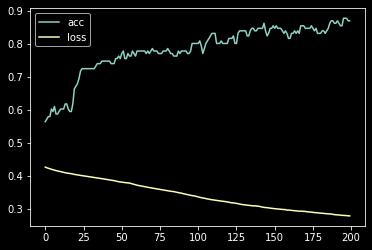

17/17 [==============================] - 0s 9ms/sample - loss: 0.4787 - accuracy: 0.8235


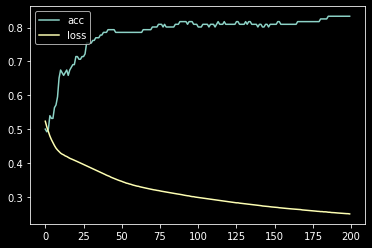

17/17 [==============================] - 0s 8ms/sample - loss: 0.5144 - accuracy: 0.8235


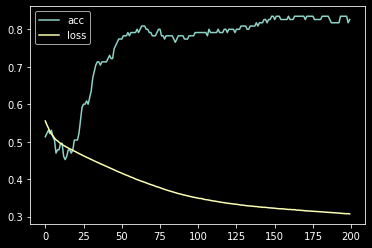

16/16 [==============================] - 0s 8ms/sample - loss: 0.6912 - accuracy: 0.6875


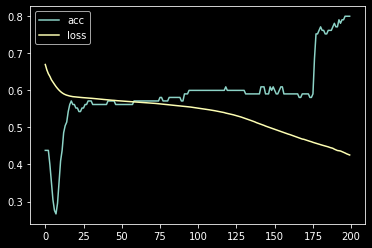

15/15 [==============================] - 0s 9ms/sample - loss: 0.7436 - accuracy: 0.5333


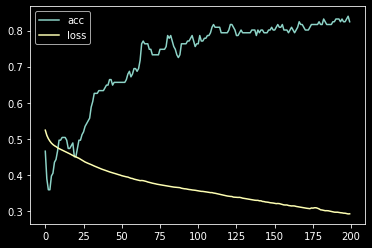

17/17 [==============================] - 0s 7ms/sample - loss: 0.5978 - accuracy: 0.7059


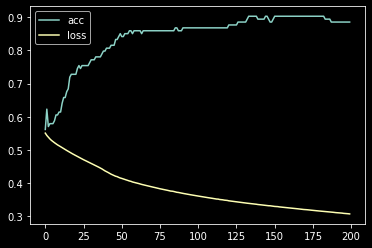

17/17 [==============================] - 0s 8ms/sample - loss: 0.7211 - accuracy: 0.5882


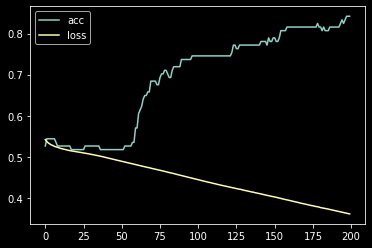

17/17 [==============================] - 0s 8ms/sample - loss: 0.6510 - accuracy: 0.7647


P:\ORD_Singh_201911038D\Maxxxx\B00\cluster_umap.py:134: RuntimeWarning: invalid value encountered in true_divide
  label_clusters = (label_clusters.T / totals).T


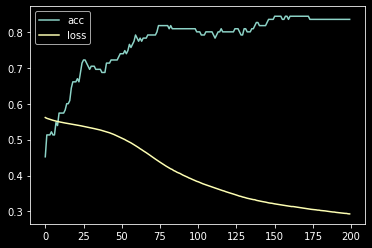

16/16 [==============================] - 0s 8ms/sample - loss: 0.6655 - accuracy: 0.6875


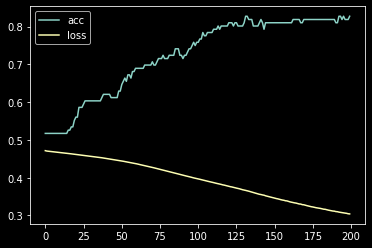

15/15 [==============================] - 0s 9ms/sample - loss: 1.2451 - accuracy: 0.2000


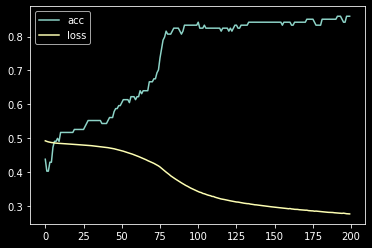

17/17 [==============================] - 0s 7ms/sample - loss: 1.1179 - accuracy: 0.3529


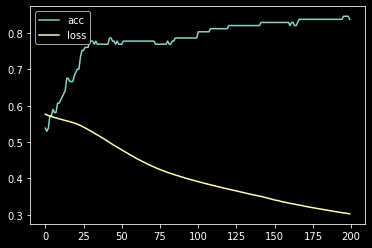

17/17 [==============================] - 0s 8ms/sample - loss: 0.7573 - accuracy: 0.6471


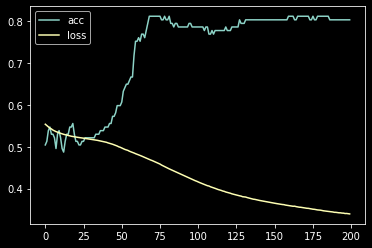

17/17 [==============================] - 0s 8ms/sample - loss: 0.7061 - accuracy: 0.5294


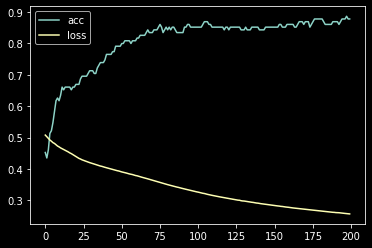

16/16 [==============================] - 0s 8ms/sample - loss: 0.4587 - accuracy: 0.7500


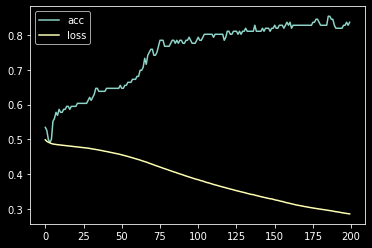

15/15 [==============================] - 0s 9ms/sample - loss: 0.5299 - accuracy: 0.6667


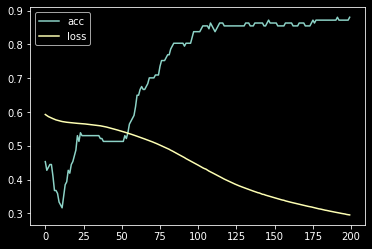

17/17 [==============================] - 0s 8ms/sample - loss: 0.7825 - accuracy: 0.6471


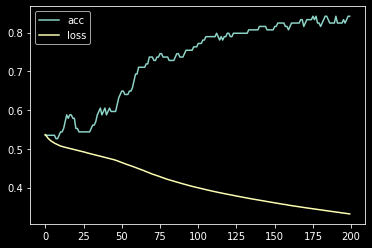

17/17 [==============================] - 0s 8ms/sample - loss: 1.7789 - accuracy: 0.2353


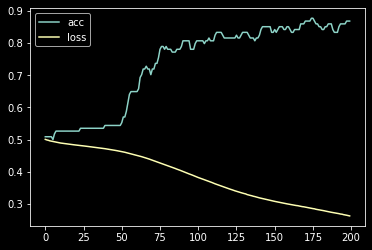

17/17 [==============================] - 0s 8ms/sample - loss: 0.5697 - accuracy: 0.7059


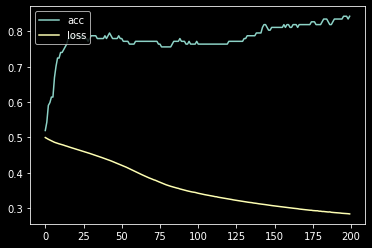

16/16 [==============================] - 0s 8ms/sample - loss: 0.7052 - accuracy: 0.6250


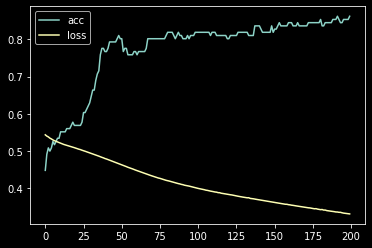

15/15 [==============================] - 0s 9ms/sample - loss: 0.5429 - accuracy: 0.7333


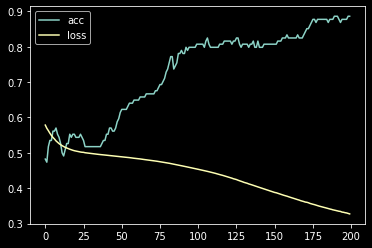

17/17 [==============================] - 0s 8ms/sample - loss: 0.4928 - accuracy: 0.7647


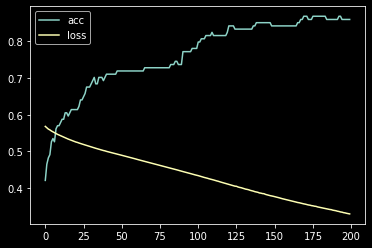

17/17 [==============================] - 0s 8ms/sample - loss: 0.4978 - accuracy: 0.7647


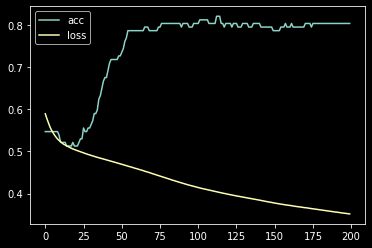

17/17 [==============================] - 0s 8ms/sample - loss: 0.6106 - accuracy: 0.7059


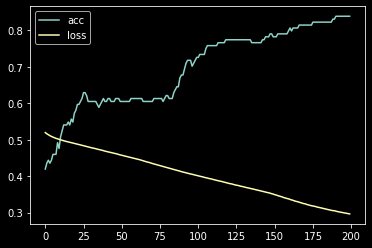

16/16 [==============================] - 0s 8ms/sample - loss: 1.0251 - accuracy: 0.3750


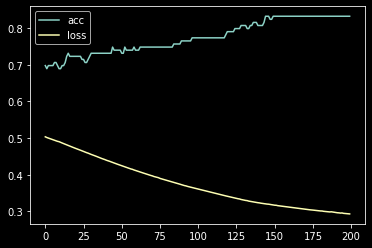

15/15 [==============================] - 0s 9ms/sample - loss: 0.9015 - accuracy: 0.4667


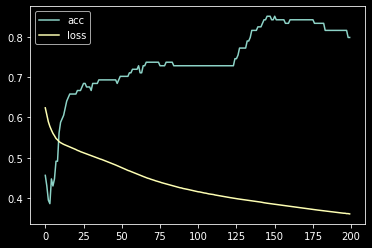

17/17 [==============================] - 0s 8ms/sample - loss: 0.7913 - accuracy: 0.5294


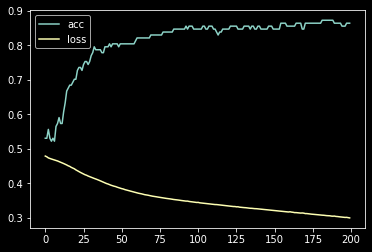

17/17 [==============================] - 0s 8ms/sample - loss: 0.4905 - accuracy: 0.7647


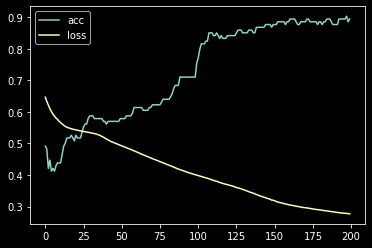

17/17 [==============================] - 0s 8ms/sample - loss: 1.0970 - accuracy: 0.3529


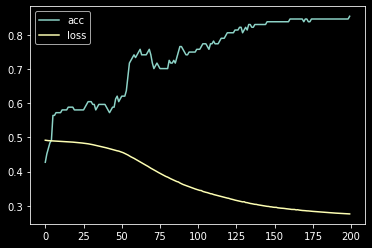

16/16 [==============================] - 0s 8ms/sample - loss: 1.3736 - accuracy: 0.2500


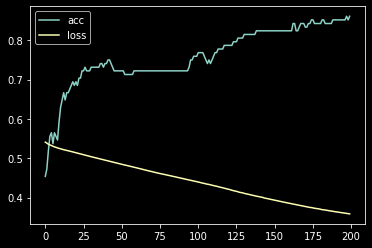

15/15 [==============================] - 0s 9ms/sample - loss: 0.7292 - accuracy: 0.4667


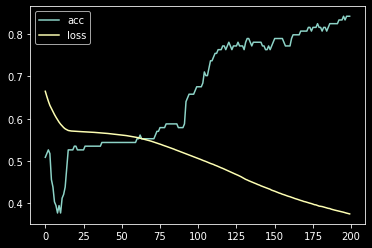

17/17 [==============================] - 0s 8ms/sample - loss: 0.6739 - accuracy: 0.7059


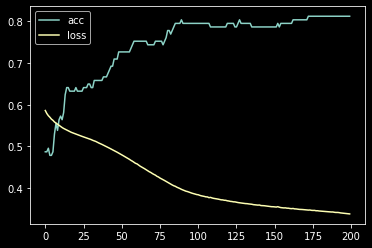

17/17 [==============================] - 0s 8ms/sample - loss: 1.1430 - accuracy: 0.4118


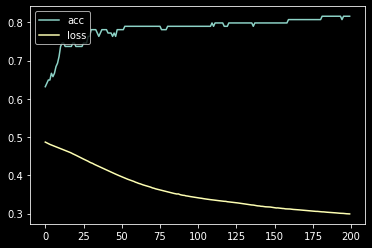

17/17 [==============================] - 0s 8ms/sample - loss: 0.5982 - accuracy: 0.6471


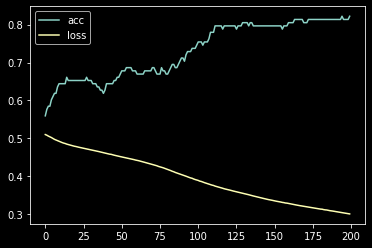

16/16 [==============================] - 0s 9ms/sample - loss: 0.8274 - accuracy: 0.5625


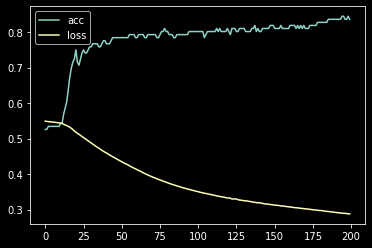

15/15 [==============================] - 0s 9ms/sample - loss: 0.7679 - accuracy: 0.5333


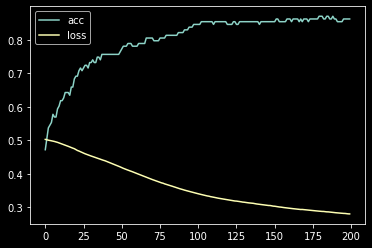

17/17 [==============================] - 0s 8ms/sample - loss: 0.8568 - accuracy: 0.5294


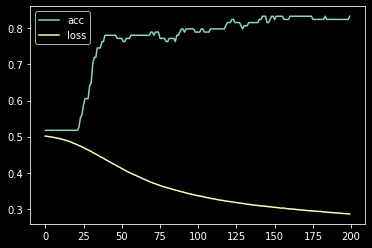

17/17 [==============================] - 0s 10ms/sample - loss: 0.6100 - accuracy: 0.7059


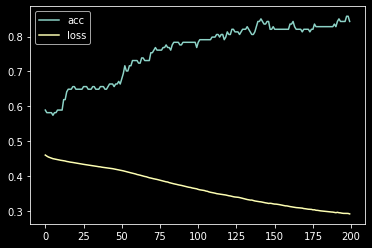

17/17 [==============================] - 0s 8ms/sample - loss: 0.6518 - accuracy: 0.5882


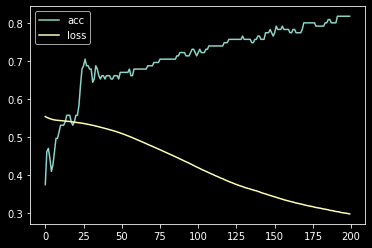

16/16 [==============================] - 0s 8ms/sample - loss: 0.7451 - accuracy: 0.7500


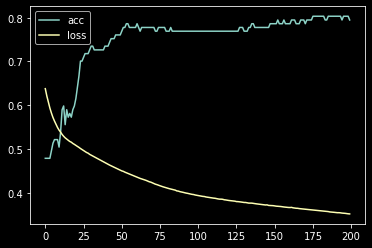

15/15 [==============================] - 0s 10ms/sample - loss: 0.6864 - accuracy: 0.7333


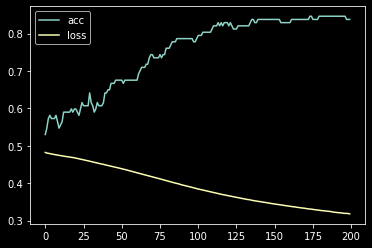

17/17 [==============================] - 0s 8ms/sample - loss: 1.2427 - accuracy: 0.2353


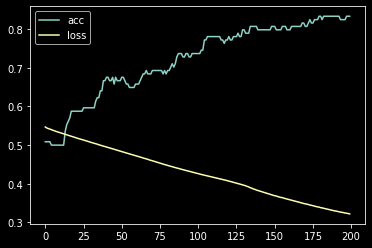

17/17 [==============================] - 0s 8ms/sample - loss: 0.6576 - accuracy: 0.6471


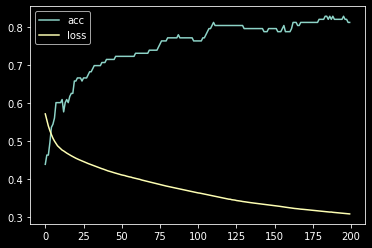

17/17 [==============================] - 0s 8ms/sample - loss: 0.6059 - accuracy: 0.7647


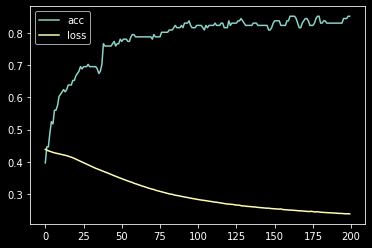

16/16 [==============================] - 0s 8ms/sample - loss: 0.6883 - accuracy: 0.6250


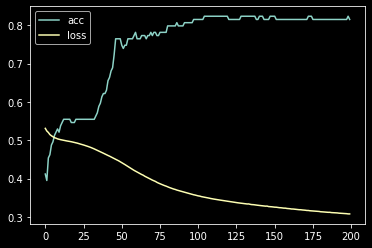

15/15 [==============================] - 0s 9ms/sample - loss: 0.5361 - accuracy: 0.7333


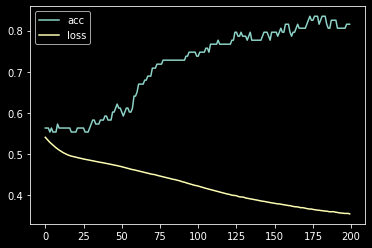

17/17 [==============================] - 0s 8ms/sample - loss: 0.5947 - accuracy: 0.5882


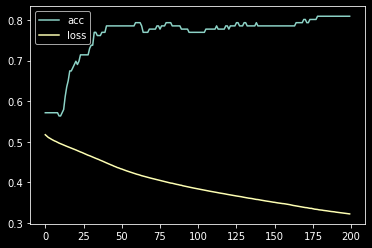

17/17 [==============================] - 0s 9ms/sample - loss: 0.8654 - accuracy: 0.4706


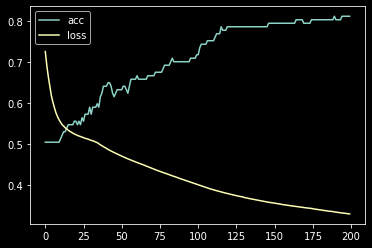

17/17 [==============================] - 0s 7ms/sample - loss: 0.6709 - accuracy: 0.5294


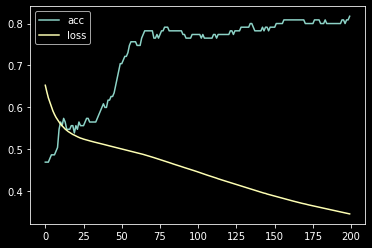

16/16 [==============================] - 0s 9ms/sample - loss: 0.6176 - accuracy: 0.6250


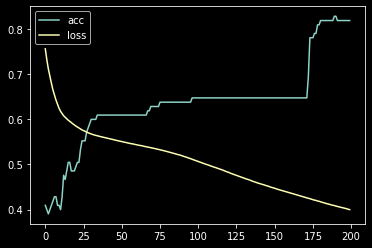

15/15 [==============================] - 0s 9ms/sample - loss: 0.6583 - accuracy: 0.6000


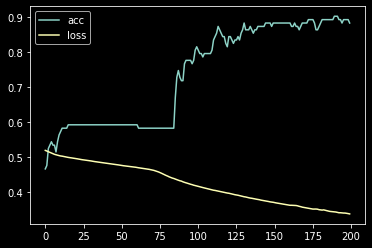

17/17 [==============================] - 0s 8ms/sample - loss: 0.6820 - accuracy: 0.6471


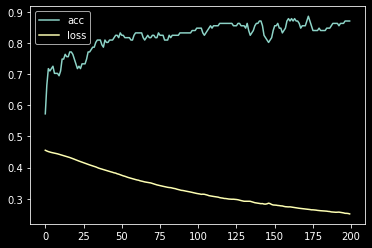

17/17 [==============================] - 0s 8ms/sample - loss: 0.6350 - accuracy: 0.5882


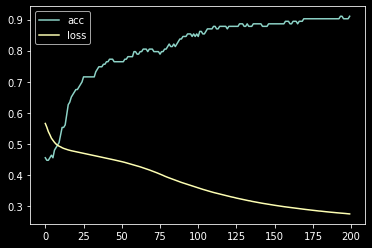

17/17 [==============================] - 0s 8ms/sample - loss: 1.0139 - accuracy: 0.4706


P:\ORD_Singh_201911038D\Maxxxx\B00\cluster_umap.py:134: RuntimeWarning: invalid value encountered in true_divide
  label_clusters = (label_clusters.T / totals).T


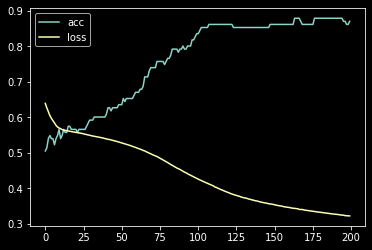

16/16 [==============================] - 0s 8ms/sample - loss: 0.7207 - accuracy: 0.6250


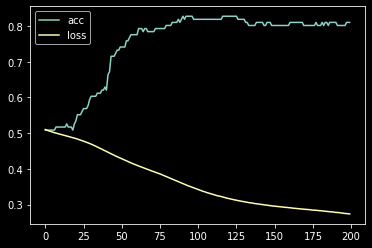

15/15 [==============================] - 0s 9ms/sample - loss: 0.9189 - accuracy: 0.5333


In [141]:
nn_pmodels, nn_presults = runClassifierEvalCV(20, trainPNN, evaluatePNN)

## Evaluating Run Results

In [37]:
lr_results_agg = aggregateListDict(lr_results)
lr_results_agg.pop("best_params")
print("(Averages, Variances):")
print(json.dumps(mapDictList(lr_results_agg, lambda x: (np.mean(np.array(x)), np.var(np.array(x)))), indent=4))

(Averages, Variances):
{
    "0.0": {
        "precision": [
            0.6309027777777778,
            0.006800612461419752
        ],
        "recall": [
            0.7125,
            0.05109375
        ],
        "f1-score": [
            0.6468031968031969,
            0.00876579713992302
        ],
        "support": [
            5.5,
            0.25
        ]
    },
    "1.0": {
        "precision": [
            0.5928571428571429,
            0.0876530612244898
        ],
        "recall": [
            0.48125,
            0.06621093750000001
        ],
        "f1-score": [
            0.48683261183261184,
            0.0418028863672803
        ],
        "support": [
            4.75,
            0.1875
        ]
    },
    "accuracy": [
        0.608459595959596,
        0.004708177099275585
    ],
    "macro avg": {
        "precision": [
            0.6118799603174603,
            0.027771404532588494
        ],
        "recall": [
            0.596875,
            0

In [142]:
nn_results_agg = aggregateListDict(nn_results)
print("(Averages, Std, Min, Max):")
print(json.dumps(mapDictList(nn_results_agg, calcMeanStdMinMax), indent=4))

(Averages, Std, Min, Max):
{
    "0.0": {
        "precision": [
            0.5985655055728585,
            0.10159533084619146,
            0.25,
            0.8333333333333334
        ],
        "recall": [
            0.7509722222222223,
            0.22543900074200904,
            0.125,
            1.0
        ],
        "f1-score": [
            0.6489252142325301,
            0.12795015467004758,
            0.18181818181818182,
            0.8571428571428571
        ],
        "support": [
            8.8,
            0.4,
            8.0,
            9.0
        ]
    },
    "1.0": {
        "precision": [
            0.5514380064380063,
            0.30814008910837254,
            0.0,
            1.0
        ],
        "recall": [
            0.3994642857142857,
            0.256032510989666,
            0.0,
            0.875
        ],
        "f1-score": [
            0.42684392757225575,
            0.23664226395290477,
            0.0,
            0.7999999999999999
  

In [143]:
nn_presults_agg = aggregateListDict(nn_presults)
print("(Averages, Std, Min, Max):")
print(json.dumps(mapDictList(nn_presults_agg, calcMeanStdMinMax), indent=4))

(Averages, Std, Min, Max):
{
    "0.0": {
        "precision": [
            0.6033879176379177,
            0.16865545864773454,
            0.0,
            1.0
        ],
        "recall": [
            0.6531944444444444,
            0.23154452382283994,
            0.0,
            1.0
        ],
        "f1-score": [
            0.617265865702028,
            0.18393614129793026,
            0.0,
            0.888888888888889
        ],
        "support": [
            8.8,
            0.4,
            8.0,
            9.0
        ]
    },
    "1.0": {
        "precision": [
            0.5854581529581528,
            0.20611767026206487,
            0.0,
            1.0
        ],
        "recall": [
            0.5171428571428571,
            0.2019029368740518,
            0.0,
            1.0
        ],
        "f1-score": [
            0.5318407653577931,
            0.18040435005907746,
            0.0,
            0.875
        ],
        "support": [
            7.6,
    

# N runs of KNN

In [191]:
def trainKNN(X_train, y_train, unlabeled_df, epochs=200):
    reducer = umap.UMAP(metric="correlation", min_dist=0, n_neighbors=5)
    knn = cluster.KNNClusterUMAPClassifier(reducer, n_neighbors=3)
    knn.fit(X_train, y_train)
    
    print(knn.score(X_train, y_train))

    return knn

def evaluateKNN(model, X_test, y_test):
    prediction = model.predict(X_test)
    result = sklearn.metrics.classification_report(y_test.to_numpy(), prediction, output_dict=True)
#     result["auc"] = sklearn.metrics.roc_auc_score(y_test.to_numpy(), prediction)
#     AUC.reset_states()
#     AUC.update_state(y_test.to_numpy(), prediction[:,0])
#     print(AUC.result())
#     AUC.reset_states()
    return result

In [186]:
knn_models, knn_results = runClassifierEvalCV(20, trainKNN, evaluateKNN)

0.6307692307692307
0.7538461538461538
0.676923076923077
0.7121212121212122
0.5970149253731343
0.676923076923077
0.6461538461538462
0.7076923076923077
0.6818181818181818
0.6417910447761194
0.6461538461538462
0.6615384615384615
0.6153846153846154
0.6515151515151515
0.6865671641791045
0.676923076923077
0.6923076923076923
0.676923076923077
0.6515151515151515
0.6716417910447762
0.6461538461538462
0.6153846153846154
0.6923076923076923
0.696969696969697
0.7313432835820896
0.6461538461538462
0.6923076923076923
0.676923076923077
0.696969696969697
0.6716417910447762
0.6923076923076923
0.676923076923077
0.6307692307692307
0.6818181818181818
0.6268656716417911
0.6153846153846154
0.7384615384615385
0.6461538461538462
0.7121212121212122
0.6865671641791045
0.6923076923076923
0.7384615384615385
0.6461538461538462
0.6212121212121212
0.7014925373134329
0.6923076923076923
0.5846153846153846
0.6461538461538462
0.5909090909090909
0.6567164179104478


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6923076923076923
0.676923076923077
0.6461538461538462
0.6818181818181818
0.6567164179104478
0.6461538461538462
0.7230769230769231
0.7230769230769231
0.6212121212121212
0.6268656716417911
0.6461538461538462
0.6615384615384615
0.7230769230769231
0.696969696969697
0.6417910447761194
0.7384615384615385
0.6615384615384615
0.676923076923077
0.7121212121212122
0.6567164179104478
0.6461538461538462
0.6153846153846154
0.6923076923076923
0.696969696969697
0.6567164179104478
0.6615384615384615
0.676923076923077
0.6153846153846154
0.696969696969697
0.7014925373134329
0.7230769230769231
0.6307692307692307
0.676923076923077
0.6818181818181818
0.6716417910447762
0.6
0.7076923076923077
0.6923076923076923
0.6666666666666666
0.6865671641791045
0.6307692307692307
0.7692307692307693
0.6615384615384615
0.6666666666666666
0.6865671641791045
0.676923076923077
0.6461538461538462
0.676923076923077
0.6666666666666666
0.6567164179104478


In [220]:
knn_results_agg = aggregateListDict(knn_results)
# knn_results_agg.pop("best_params")
print("(Averages, Std, Min, Max):")
print(json.dumps(mapDictList(knn_results_agg, calcMeanStdMinMax), indent=4))

(Averages, Std, Min, Max):
{
    "0.0": {
        "precision": [
            0.5722640692640693,
            0.10351577009183394,
            0.25,
            0.8
        ],
        "recall": [
            0.6563888888888889,
            0.2050916311322669,
            0.125,
            1.0
        ],
        "f1-score": [
            0.5990447557056994,
            0.13164872281187268,
            0.16666666666666666,
            0.8
        ],
        "support": [
            8.8,
            0.4,
            8.0,
            9.0
        ]
    },
    "1.0": {
        "precision": [
            0.5430472582972583,
            0.20547667441838505,
            0.0,
            1.0
        ],
        "recall": [
            0.4316071428571428,
            0.19443886755040954,
            0.0,
            0.8571428571428571
        ],
        "f1-score": [
            0.4550925924780414,
            0.16081078657545772,
            0.0,
            0.75
        ],
        "support": [
 

In [190]:
def trainKNN2(X_train, y_train, unlabeled_df, epochs=200):
    reducer = umap.UMAP(metric="correlation", min_dist=0, n_neighbors=5)
    knn = cluster.HeuristicKNNClusterClassifier(reducer, n_neighbors=3, c=1)
    knn.fit(X_train, y_train)
    
    print(knn.score(X_train, y_train))

    return knn

In [192]:
knn_models2, knn_results2 = runClassifierEvalCV(20, trainKNN2, evaluateKNN)

0.6307692307692307
0.7384615384615385
0.676923076923077
0.696969696969697
0.6268656716417911
0.6923076923076923
0.6615384615384615
0.7538461538461538
0.6818181818181818
0.6268656716417911
0.7076923076923077
0.676923076923077
0.676923076923077
0.6515151515151515
0.6567164179104478
0.676923076923077
0.6923076923076923
0.676923076923077
0.6515151515151515
0.6716417910447762
0.676923076923077
0.6307692307692307
0.676923076923077
0.6818181818181818
0.7313432835820896
0.6461538461538462
0.6615384615384615
0.676923076923077
0.7121212121212122
0.6716417910447762
0.7076923076923077
0.6615384615384615
0.6307692307692307
0.6818181818181818
0.6268656716417911
0.6461538461538462
0.7230769230769231
0.6153846153846154
0.696969696969697
0.6567164179104478
0.7076923076923077
0.7076923076923077
0.6461538461538462
0.6212121212121212
0.7014925373134329
0.7076923076923077
0.6307692307692307
0.6307692307692307
0.6060606060606061
0.6716417910447762
0.676923076923077
0.676923076923077
0.6461538461538462
0.666

In [219]:
knn_results_agg2 = aggregateListDict(knn_results2)
# knn_results_agg.pop("best_params")
print("(Averages, Std, Min, Max):")
print(json.dumps(mapDictList(knn_results_agg2, calcMeanStdMinMax), indent=4))

(Averages, Std, Min, Max):
{
    "0.0": {
        "precision": [
            0.569910409035409,
            0.10875868767880213,
            0.25,
            0.8
        ],
        "recall": [
            0.6459722222222222,
            0.1969432201027607,
            0.1111111111111111,
            1.0
        ],
        "f1-score": [
            0.5937293019748532,
            0.13697878859199383,
            0.16666666666666666,
            0.7999999999999999
        ],
        "support": [
            8.8,
            0.4,
            8.0,
            9.0
        ]
    },
    "1.0": {
        "precision": [
            0.5278195693195693,
            0.1789301504542566,
            0.0,
            1.0
        ],
        "recall": [
            0.4371428571428572,
            0.19175412083484114,
            0.0,
            0.875
        ],
        "f1-score": [
            0.45787201528822213,
            0.1570014240711457,
            0.0,
            0.75
        ],
        "

In [207]:
def trainKNN3(X_train, y_train, unlabeled_df, epochs=200):
    reducer = umap.UMAP(metric="correlation", min_dist=0, n_neighbors=5)
    knn = cluster.HeuristicKNNClusterClassifier(reducer, n_neighbors=3, c=1)
    
    logreg = LogisticRegression(penalty="l2", C=2.15443469e-02, solver="liblinear") # chose the most common best
    
    model = cluster.KNNClusterLogisticRegression(knn, logreg)
    model.fit(X_train, y_train)
    
    print(model.score(X_train, y_train))

    return model

In [208]:
knn_models3, knn_results3 = runClassifierEvalCV(20, trainKNN3, evaluateKNN)

0.6
0.7076923076923077
0.6923076923076923
0.6515151515151515
0.5970149253731343
0.6307692307692307
0.6615384615384615
0.6615384615384615
0.696969696969697
0.6417910447761194
0.6615384615384615
0.676923076923077
0.6461538461538462
0.6818181818181818
0.6417910447761194
0.5846153846153846
0.6615384615384615
0.676923076923077
0.6666666666666666
0.5671641791044776
0.6
0.6307692307692307
0.7076923076923077
0.6666666666666666
0.7014925373134329
0.6461538461538462
0.6
0.6307692307692307
0.6818181818181818
0.6417910447761194
0.6615384615384615
0.6307692307692307
0.6307692307692307
0.6818181818181818
0.6268656716417911
0.6615384615384615
0.7076923076923077
0.6153846153846154
0.6666666666666666
0.6417910447761194
0.7076923076923077
0.6923076923076923
0.6461538461538462
0.6060606060606061
0.6716417910447762
0.7076923076923077
0.5692307692307692
0.6307692307692307
0.6212121212121212
0.6567164179104478


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6923076923076923
0.6307692307692307
0.6461538461538462
0.6666666666666666
0.6567164179104478
0.6461538461538462
0.6615384615384615
0.6923076923076923
0.6363636363636364
0.6268656716417911
0.6153846153846154
0.6615384615384615
0.7076923076923077
0.6363636363636364


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6268656716417911
0.6307692307692307
0.6461538461538462
0.6307692307692307
0.6515151515151515
0.6716417910447762
0.6307692307692307
0.6153846153846154
0.676923076923077
0.6515151515151515
0.6865671641791045
0.6
0.6615384615384615
0.6
0.6212121212121212
0.7014925373134329
0.7384615384615385
0.6461538461538462
0.676923076923077
0.6363636363636364
0.6268656716417911
0.6307692307692307
0.6615384615384615
0.676923076923077
0.6363636363636364
0.7014925373134329
0.6153846153846154
0.6923076923076923
0.6615384615384615
0.6212121212121212
0.6417910447761194
0.6615384615384615
0.6461538461538462
0.676923076923077
0.6363636363636364
0.6119402985074627


In [218]:
knn_results_agg3 = aggregateListDict(knn_results3)
# knn_results_agg.pop("best_params")
print("(Averages, Std, Min, Max):")
print(json.dumps(mapDictList(knn_results_agg3, calcMeanStdMinMax), indent=4))

(Averages, Std, Min, Max):
{
    "0.0": {
        "precision": [
            0.5757110944610944,
            0.07085138746190492,
            0.2727272727272727,
            0.7777777777777778
        ],
        "recall": [
            0.8229166666666665,
            0.14765887812835182,
            0.3333333333333333,
            1.0
        ],
        "f1-score": [
            0.6736252422694341,
            0.08862257407106958,
            0.3,
            0.8181818181818181
        ],
        "support": [
            8.8,
            0.4,
            8.0,
            9.0
        ]
    },
    "1.0": {
        "precision": [
            0.6117936507936507,
            0.26677712352388183,
            0.0,
            1.0
        ],
        "recall": [
            0.29624999999999996,
            0.152949217095754,
            0.0,
            0.7142857142857143
        ],
        "f1-score": [
            0.3802382747970983,
            0.16713206577010167,
            0.0,
         

In [211]:
def trainKNN4(X_train, y_train, unlabeled_df, epochs=200):
    reducer = umap.UMAP(metric="correlation", min_dist=0, n_neighbors=5)
    knn = cluster.HeuristicKNNClusterClassifier(reducer, n_neighbors=5, c=1)
    
    logreg = LogisticRegression(penalty="l2", C=2.15443469e-02, solver="liblinear") # chose the most common best
    
    model = cluster.KNNClusterLogisticRegression(knn, logreg)
    model.fit(X_train, y_train)
    
    print(model.score(X_train, y_train))

    return model

In [212]:
knn_models4, knn_results4 = runClassifierEvalCV(20, trainKNN4, evaluateKNN)

0.5692307692307692
0.6615384615384615
0.7076923076923077
0.6515151515151515
0.5970149253731343
0.6461538461538462
0.6461538461538462
0.6615384615384615
0.6818181818181818
0.5671641791044776
0.6153846153846154
0.676923076923077
0.5846153846153846
0.6060606060606061
0.6716417910447762
0.5692307692307692
0.676923076923077
0.6307692307692307
0.6666666666666666
0.5373134328358209


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6
0.6307692307692307
0.6923076923076923
0.6515151515151515
0.7014925373134329
0.6461538461538462
0.6307692307692307
0.7076923076923077
0.6666666666666666
0.6417910447761194
0.6153846153846154
0.6307692307692307
0.6307692307692307
0.6818181818181818
0.6268656716417911
0.6461538461538462


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6923076923076923
0.6153846153846154
0.6666666666666666
0.6417910447761194
0.6923076923076923
0.676923076923077
0.6461538461538462
0.6363636363636364
0.7014925373134329
0.6923076923076923
0.6461538461538462
0.6307692307692307
0.6060606060606061
0.6716417910447762


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6615384615384615
0.6307692307692307
0.6461538461538462
0.696969696969697
0.6268656716417911
0.6461538461538462
0.6615384615384615
0.6615384615384615
0.5909090909090909
0.6119402985074627
0.6461538461538462
0.6153846153846154
0.7230769230769231
0.6363636363636364


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6417910447761194
0.6
0.6153846153846154
0.6307692307692307
0.6363636363636364
0.6567164179104478
0.6
0.6153846153846154
0.6307692307692307
0.6818181818181818
0.7014925373134329
0.6
0.6615384615384615
0.6
0.6363636363636364
0.6567164179104478
0.7076923076923077
0.6615384615384615
0.6615384615384615
0.6363636363636364


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6716417910447762
0.5538461538461539
0.676923076923077
0.6
0.6515151515151515
0.6567164179104478
0.6
0.6923076923076923
0.676923076923077
0.6515151515151515
0.6268656716417911
0.6461538461538462
0.6461538461538462
0.6461538461538462
0.6363636363636364
0.5970149253731343


In [217]:
knn_results_agg4 = aggregateListDict(knn_results4)
# knn_results_agg.pop("best_params")
print("(Averages, Std, Min, Max):")
print(json.dumps(mapDictList(knn_results_agg4, calcMeanStdMinMax), indent=4))

(Averages, Std, Min, Max):
{
    "0.0": {
        "precision": [
            0.5724603403132814,
            0.06276732474494216,
            0.3333333333333333,
            0.7777777777777778
        ],
        "recall": [
            0.8397222222222221,
            0.13844958301503488,
            0.4444444444444444,
            1.0
        ],
        "f1-score": [
            0.6768090345513958,
            0.07760966153558964,
            0.380952380952381,
            0.8181818181818181
        ],
        "support": [
            8.8,
            0.4,
            8.0,
            9.0
        ]
    },
    "1.0": {
        "precision": [
            0.5916349206349206,
            0.2878549310421325,
            0.0,
            1.0
        ],
        "recall": [
            0.2691071428571428,
            0.15834070650573304,
            0.0,
            0.7142857142857143
        ],
        "f1-score": [
            0.3495485886662357,
            0.17575893846819812,
            

In [214]:
def trainKNN5(X_train, y_train, unlabeled_df, epochs=200):
    reducer = umap.UMAP(metric="correlation", min_dist=0, n_neighbors=5)
    knn = cluster.HeuristicKNNClusterClassifier(reducer, n_neighbors=5, c=1)
    
    logreg = LogisticRegression(penalty="l2", C=2.15443469e-02, solver="liblinear") # chose the most common best
    
    model = cluster.KNNClusterLogisticRegression(knn, logreg, 0.75)
    model.fit(X_train, y_train)
    
    print(model.score(X_train, y_train))

    return model

In [215]:
knn_models5, knn_results5 = runClassifierEvalCV(20, trainKNN5, evaluateKNN)

0.5384615384615384


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6615384615384615
0.6153846153846154
0.5303030303030303


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5522388059701493


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5846153846153846
0.6153846153846154
0.6818181818181818
0.5522388059701493
0.5692307692307692


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.676923076923077
0.5846153846153846
0.5757575757575758
0.5373134328358209


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5692307692307692
0.6615384615384615
0.5384615384615384


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6666666666666666
0.5373134328358209


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5538461538461539


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5384615384615384


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.676923076923077
0.5454545454545454


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6567164179104478
0.6615384615384615
0.5384615384615384


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6
0.6060606060606061
0.6417910447761194
0.5538461538461539


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5384615384615384


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5692307692307692
0.6818181818181818
0.582089552238806
0.5846153846153846


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6615384615384615
0.5384615384615384


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6363636363636364
0.6417910447761194
0.5384615384615384


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.676923076923077
0.5384615384615384


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5303030303030303


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6417910447761194
0.676923076923077
0.5692307692307692
0.5538461538461539
0.5303030303030303


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6865671641791045


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5384615384615384


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6307692307692307
0.676923076923077
0.5303030303030303


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5522388059701493


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5384615384615384


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6615384615384615
0.6461538461538462
0.5454545454545454


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.582089552238806
0.5538461538461539
0.5846153846153846
0.6615384615384615
0.6515151515151515


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5671641791044776


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5692307692307692
0.5384615384615384


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5384615384615384


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6363636363636364
0.6567164179104478
0.6153846153846154
0.5384615384615384


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5384615384615384


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6212121212121212
0.5522388059701493


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5846153846153846


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6
0.5846153846153846
0.5303030303030303


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6865671641791045
0.5538461538461539
0.6461538461538462
0.6
0.5757575757575758


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5970149253731343
0.5384615384615384


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6615384615384615
0.5384615384615384


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6212121212121212
0.6567164179104478
0.5384615384615384


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6615384615384615
0.6615384615384615
0.5303030303030303


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5373134328358209


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6461538461538462
0.5538461538461539
0.6461538461538462
0.6666666666666666
0.6417910447761194


In [221]:
knn_results_agg5 = aggregateListDict(knn_results5)
# knn_results_agg.pop("best_params")
print("(Averages, Std, Min, Max):")
print(json.dumps(mapDictList(knn_results_agg5, calcMeanStdMinMax), indent=4))

(Averages, Std, Min, Max):
{
    "0.0": {
        "precision": [
            0.5521880325556796,
            0.03675078076170275,
            0.46153846153846156,
            0.7
        ],
        "recall": [
            0.9180555555555554,
            0.0942706734702962,
            0.6666666666666666,
            1.0
        ],
        "f1-score": [
            0.6868217328057148,
            0.036640337532220325,
            0.5714285714285714,
            0.761904761904762
        ],
        "support": [
            8.8,
            0.4,
            8.0,
            9.0
        ]
    },
    "1.0": {
        "precision": [
            0.3303809523809524,
            0.3525342523684337,
            0.0,
            1.0
        ],
        "recall": [
            0.12839285714285714,
            0.1497168884383905,
            0.0,
            0.5714285714285714
        ],
        "f1-score": [
            0.17609890109890106,
            0.19197882966461655,
            0.0,
        

In [225]:
def trainKNN6(X_train, y_train, unlabeled_df, epochs=200):
    reducer = umap.UMAP(metric="correlation", min_dist=0, n_neighbors=5)
    knn = cluster.HeuristicKNNClusterClassifier(reducer, n_neighbors=3, c=0.000001)
    knn.fit(X_train, y_train)
    
    print(knn.score(X_train, y_train))

    return knn

In [226]:
knn_models6, knn_results6 = runClassifierEvalCV(20, trainKNN6, evaluateKNN)

0.6153846153846154
0.7230769230769231
0.7230769230769231
0.6666666666666666
0.6417910447761194
0.6923076923076923
0.6923076923076923
0.7384615384615385
0.696969696969697
0.6567164179104478
0.7076923076923077
0.6923076923076923
0.6923076923076923
0.6818181818181818
0.6865671641791045
0.6923076923076923
0.7076923076923077
0.6615384615384615
0.696969696969697
0.7014925373134329
0.6615384615384615
0.6461538461538462
0.7230769230769231
0.6666666666666666
0.7313432835820896
0.6461538461538462
0.6615384615384615
0.7076923076923077
0.696969696969697
0.7014925373134329
0.6923076923076923
0.6615384615384615
0.6461538461538462
0.6818181818181818
0.6417910447761194
0.676923076923077
0.7538461538461538
0.6461538461538462
0.696969696969697
0.6716417910447762
0.7076923076923077
0.7230769230769231
0.6615384615384615
0.6363636363636364
0.7014925373134329
0.7230769230769231
0.676923076923077
0.6461538461538462
0.696969696969697
0.6716417910447762


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7076923076923077
0.6615384615384615
0.6923076923076923
0.6818181818181818
0.6716417910447762
0.6307692307692307
0.7230769230769231
0.7230769230769231
0.6818181818181818
0.6567164179104478
0.6923076923076923
0.6923076923076923
0.7538461538461538
0.7121212121212122
0.6417910447761194
0.7230769230769231
0.6461538461538462
0.6461538461538462
0.7121212121212122
0.7164179104477612
0.7230769230769231
0.676923076923077
0.7230769230769231
0.696969696969697
0.6865671641791045
0.676923076923077
0.7076923076923077
0.6461538461538462
0.6666666666666666
0.7014925373134329
0.7384615384615385
0.6615384615384615
0.7230769230769231
0.6818181818181818
0.6865671641791045
0.6307692307692307
0.7230769230769231
0.7076923076923077
0.7121212121212122
0.7014925373134329
0.6461538461538462
0.7384615384615385
0.6615384615384615
0.6515151515151515
0.7014925373134329
0.6923076923076923
0.7230769230769231
0.676923076923077
0.6818181818181818
0.7014925373134329


In [227]:
knn_results_agg6 = aggregateListDict(knn_results6)
# knn_results_agg.pop("best_params")
print("(Averages, Std, Min, Max):")
print(json.dumps(mapDictList(knn_results_agg6, calcMeanStdMinMax), indent=4))

(Averages, Std, Min, Max):
{
    "0.0": {
        "precision": [
            0.5759173465423465,
            0.11349450347451528,
            0.16666666666666666,
            0.8
        ],
        "recall": [
            0.6468055555555555,
            0.2082430823032556,
            0.1111111111111111,
            1.0
        ],
        "f1-score": [
            0.5973127675886728,
            0.1426894530125169,
            0.13333333333333333,
            0.8571428571428571
        ],
        "support": [
            8.8,
            0.4,
            8.0,
            9.0
        ]
    },
    "1.0": {
        "precision": [
            0.5380811133311133,
            0.20139998100648587,
            0.0,
            1.0
        ],
        "recall": [
            0.4523214285714286,
            0.19530612744706027,
            0.0,
            0.8571428571428571
        ],
        "f1-score": [
            0.4703819703688125,
            0.16733815248781764,
            0.0,
        

In [238]:
def trainKNN7(X_train, y_train, unlabeled_df, epochs=200):
    reducer = umap.UMAP(metric="correlation", min_dist=0, n_neighbors=5)
    knn = cluster.PickyHeuristicKNNClusterClassifier(reducer, n_neighbors=3, c=0.000001)
    knn.fit(X_train, y_train)
    
#     print(knn.score(X_train, y_train))

    return knn

def evaluateKNN7(model, X_test, y_test):
    prediction_proba = model.predict_proba(X_test)
    result = sklearn.metrics.classification_report(y_test.to_numpy()[prediction_proba!=0.5], 
                                                   (prediction_proba[prediction_proba!=0.5]>0.5).astype(int), 
                                                   output_dict=True)
    result["dumped"] = prediction_proba[prediction_proba==0.5].shape[0]
#     result["auc"] = sklearn.metrics.roc_auc_score(y_test.to_numpy(), prediction)
#     AUC.reset_states()
#     AUC.update_state(y_test.to_numpy(), prediction[:,0])
#     print(AUC.result())
#     AUC.reset_states()
    return result

In [239]:
knn_models7, knn_results7 = runClassifierEvalCV(20, trainKNN7, evaluateKNN7)

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [240]:
knn_results_agg7 = aggregateListDict(knn_results7)
# knn_results_agg.pop("best_params")
print("(Averages, Std, Min, Max):")
print(json.dumps(mapDictList(knn_results_agg7, calcMeanStdMinMax), indent=4))

(Averages, Std, Min, Max):
{
    "0.0": {
        "precision": [
            0.6834285714285714,
            0.26639504023220373,
            0.0,
            1.0
        ],
        "recall": [
            0.6271428571428571,
            0.2576595338312745,
            0.0,
            1.0
        ],
        "f1-score": [
            0.6164601509601508,
            0.21166630334232364,
            0.0,
            1.0
        ],
        "support": [
            3.89,
            1.509271347372632,
            1.0,
            8.0
        ]
    },
    "1.0": {
        "precision": [
            0.6169325396825396,
            0.2651232501870508,
            0.0,
            1.0
        ],
        "recall": [
            0.6723333333333333,
            0.2949925591897603,
            0.0,
            1.0
        ],
        "f1-score": [
            0.6126167851756086,
            0.23498283254711264,
            0.0,
            1.0
        ],
        "support": [
            3.59,
     

In [242]:
def evaluateKNN8(model, X_test, y_test):
    prediction_proba = model.predict_proba(X_test, threshold=0.6)
    result = sklearn.metrics.classification_report(y_test.to_numpy()[prediction_proba!=0.5], 
                                                   (prediction_proba[prediction_proba!=0.5]>0.5).astype(int), 
                                                   output_dict=True)
    result["dumped"] = prediction_proba[prediction_proba==0.5].shape[0]
#     result["auc"] = sklearn.metrics.roc_auc_score(y_test.to_numpy(), prediction)
#     AUC.reset_states()
#     AUC.update_state(y_test.to_numpy(), prediction[:,0])
#     print(AUC.result())
#     AUC.reset_states()
    return result

In [244]:
knn_models8, knn_results8 = runClassifierEvalCV(20, trainKNN7, evaluateKNN8)

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [245]:
knn_results_agg8 = aggregateListDict(knn_results8)
# knn_results_agg.pop("best_params")
print("(Averages, Std, Min, Max):")
print(json.dumps(mapDictList(knn_results_agg8, calcMeanStdMinMax), indent=4))

(Averages, Std, Min, Max):
{
    "0.0": {
        "precision": [
            0.632840354090354,
            0.2235288770412517,
            0.0,
            1.0
        ],
        "recall": [
            0.62825,
            0.24389236056987038,
            0.0,
            1.0
        ],
        "f1-score": [
            0.6000269292111396,
            0.18985018162188583,
            0.0,
            1.0
        ],
        "support": [
            4.85,
            1.681517172080024,
            2.0,
            9.0
        ]
    },
    "1.0": {
        "precision": [
            0.6006212121212121,
            0.23099523918893933,
            0.0,
            1.0
        ],
        "recall": [
            0.5949880952380953,
            0.270777220508407,
            0.0,
            1.0
        ],
        "f1-score": [
            0.566597125097125,
            0.2094702448638196,
            0.0,
            1.0
        ],
        "support": [
            4.49,
            1.47305

In [249]:
def evaluateKNN9(model, X_test, y_test):
    prediction_proba = model.predict_proba(X_test, threshold=0.8)
    if prediction_proba[prediction_proba==0.5].shape[0] == prediction_proba.shape[0]:
        return None
#     print(prediction_proba)
#     print(y_test.to_numpy()[prediction_proba!=0.5])
#     print((prediction_proba[prediction_proba!=0.5]>0.5).astype(int))
    result = sklearn.metrics.classification_report(y_test.to_numpy()[prediction_proba!=0.5], 
                                                   (prediction_proba[prediction_proba!=0.5]>0.5).astype(int), 
                                                   output_dict=True)
    result["dumped"] = prediction_proba[prediction_proba==0.5].shape[0]
#     result["auc"] = sklearn.metrics.roc_auc_score(y_test.to_numpy(), prediction)
#     AUC.reset_states()
#     AUC.update_state(y_test.to_numpy(), prediction[:,0])
#     print(AUC.result())
#     AUC.reset_states()
    return result

In [250]:
knn_models9, knn_results9 = runClassifierEvalCV(20, trainKNN7, evaluateKNN9)

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarn

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarn

In [258]:
knn_results_agg9 = aggregateListDict(list(filter(None, knn_results9)))
# knn_results_agg.pop("best_params")
print("(Averages, Std, Min, Max):")
print(json.dumps(mapDictList(knn_results_agg9, calcMeanStdMinMax), indent=4))

(Averages, Std, Min, Max):
{
    "0.0": {
        "precision": [
            0.6654471544715447,
            0.387515018397704,
            0.0,
            1.0
        ],
        "recall": [
            0.6808943089430893,
            0.40003490660038304,
            0.0,
            1.0
        ],
        "f1-score": [
            0.6336333720480061,
            0.35743427350706725,
            0.0,
            1.0
        ],
        "support": [
            1.8658536585365855,
            0.9723267934281778,
            0.0,
            4.0
        ]
    },
    "1.0": {
        "precision": [
            0.2383876357560568,
            0.28079589760747475,
            0.0,
            1.0
        ],
        "recall": [
            0.39941520467836256,
            0.45488431055284967,
            0.0,
            1.0
        ],
        "f1-score": [
            0.2865269233690287,
            0.3246764570008906,
            0.0,
            1.0
        ],
        "support": [
       